# Level 6 Data Science Integrated Apprenticeship Degree BSc (Hons) 
## Module 2 | Data Analytics | Summative Submission

### Logistic Regression - Employee Turnover


In [1]:
# Standard Library Imports
import re

# Third-Party Library Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sweetviz as sv
import shap
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from yellowbrick.classifier import ClassificationReport
from lazypredict.Supervised import LazyClassifier
import sklearn.metrics as met
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# Remove duplicate imports
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as met


In [2]:
# read the dataset in using pandas to a dataframe 
df = pd.read_csv("~/data_analytics_m2_summative_submission/data/company_x_employee_satisfaction_dataset.csv")

# check the dataframe can be read and viewed
print("\nFirst five rows of the dataset:")

df.head(5)


First five rows of the dataset:


,EmployeeId,Age,Gender,MaritalStatus,Turnover,Department,Role,RoleGrade,QualificationsHeld,YearsWorkExperience,...,RegularOvertime,PercentSalaryHike,ContractHours,SharesOptionLevel,TrainingTimesLastYear,WorkLifeBalanceScore,YearsAtCompany,YearsInCurrentRole,YearsWithCurrentManager,DistanceFromHome
0,1,46,F,Divorced,No,Research & Development,Manager,3,3,0,...,No,14,37.50,0,3,4,25,16,13,4
1,2,35,M,Divorced,No,Research & Development,Manufacturing Director,2,4,2,...,Yes,16,37.50,1,2,3,7,1,1,10
2,3,29,M,Single,No,Sales,Sales Representative,1,3,2,...,No,21,37.50,0,2,1,3,1,2,2
3,4,26,M,Divorced,No,Sales,Sales Representative,1,3,7,...,No,19,37.50,1,3,3,4,1,1,1
4,5,41,F,Single,No,Research & Development,Healthcare Representative,2,2,1,...,No,14,37.50,0,3,3,10,7,7,2


In [3]:
# check for number of datapoints, total attributes, null values & datatypes 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 27 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   EmployeeId                                    1470 non-null   int64  
 1   Age                                           1470 non-null   int64  
 2   Gender                                        1470 non-null   object 
 3   MaritalStatus                                 1470 non-null   object 
 4   Turnover                                      1470 non-null   object 
 5   Department                                    1470 non-null   object 
 6   Role                                          1470 non-null   object 
 7   RoleGrade                                     1470 non-null   int64  
 8   QualificationsHeld                            1470 non-null   int64  
 9   YearsWorkExperience                           1470 non-null   i

In [4]:
# rename columns using lambda function for camel case to snake case conversion

df.columns = df.columns.map(lambda x: re.sub(r'(?<!^)(?=[A-Z])', '_', x).lower())
df.columns

Index(['employee_id', 'age', 'gender', 'marital_status', 'turnover',
       'department', 'role', 'role_grade', 'qualifications_held',
       'years_work_experience', 'education_field',
       'employee_satisfaction_score', 'job_engagement_score',
       'job_satisfaction_score',
       'previous_manager_relationship_satisfaction_score',
       'manager_relationship_satisfaction_score', 'traveling',
       'regular_overtime', 'percent_salary_hike', 'contract_hours',
       'shares_option_level', 'training_times_last_year',
       'work_life_balance_score', 'years_at_company', 'years_in_current_role',
       'years_with_current_manager', 'distance_from_home'],
      dtype='object')

In [5]:
# Count the number of currently employed employees
employed_count = df[df['turnover'] == 'No'].shape[0]

# Count the number of ex-employees (those who have left the company)
ex_employees_count = df[df['turnover'] == 'Yes'].shape[0]

# Display the total number of employees
total_employees = len(df)
print("Total number of employees:", total_employees)

# Display the number of currently employed employees and ex-employees
print("Number of currently employed employees:", employed_count)
print("Number of ex-employees:", ex_employees_count)

Total number of employees: 1470
Number of currently employed employees: 1203
Number of ex-employees: 267


In [6]:
# as 'EmployeeId' would be our primary key, we will check for duplicates in this column

duplicate_employee = df[df.duplicated(subset=['employee_id'], keep=False)]

# Print or display the duplicate rows
print("Number of duplicate employees:", len(duplicate_employee))

Number of duplicate employees: 0


In [7]:
# check for duplicate data points 

duplicate_rows = df.duplicated().sum()

print("Number of Duplicate Datapoints:", duplicate_rows)

Number of Duplicate Datapoints: 0


In [8]:
# Numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)


Numerical columns: ['employee_id', 'age', 'role_grade', 'qualifications_held', 'years_work_experience', 'employee_satisfaction_score', 'job_engagement_score', 'job_satisfaction_score', 'previous_manager_relationship_satisfaction_score', 'manager_relationship_satisfaction_score', 'percent_salary_hike', 'contract_hours', 'shares_option_level', 'training_times_last_year', 'work_life_balance_score', 'years_at_company', 'years_in_current_role', 'years_with_current_manager', 'distance_from_home']
Categorical columns: ['gender', 'marital_status', 'turnover', 'department', 'role', 'education_field', 'traveling', 'regular_overtime']


                                             |          | [  0%]   00:00 -> (? left)


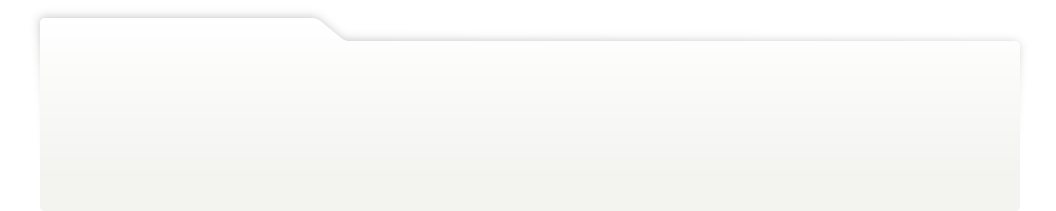
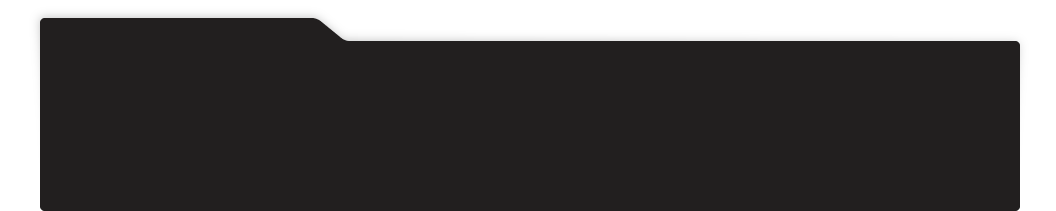
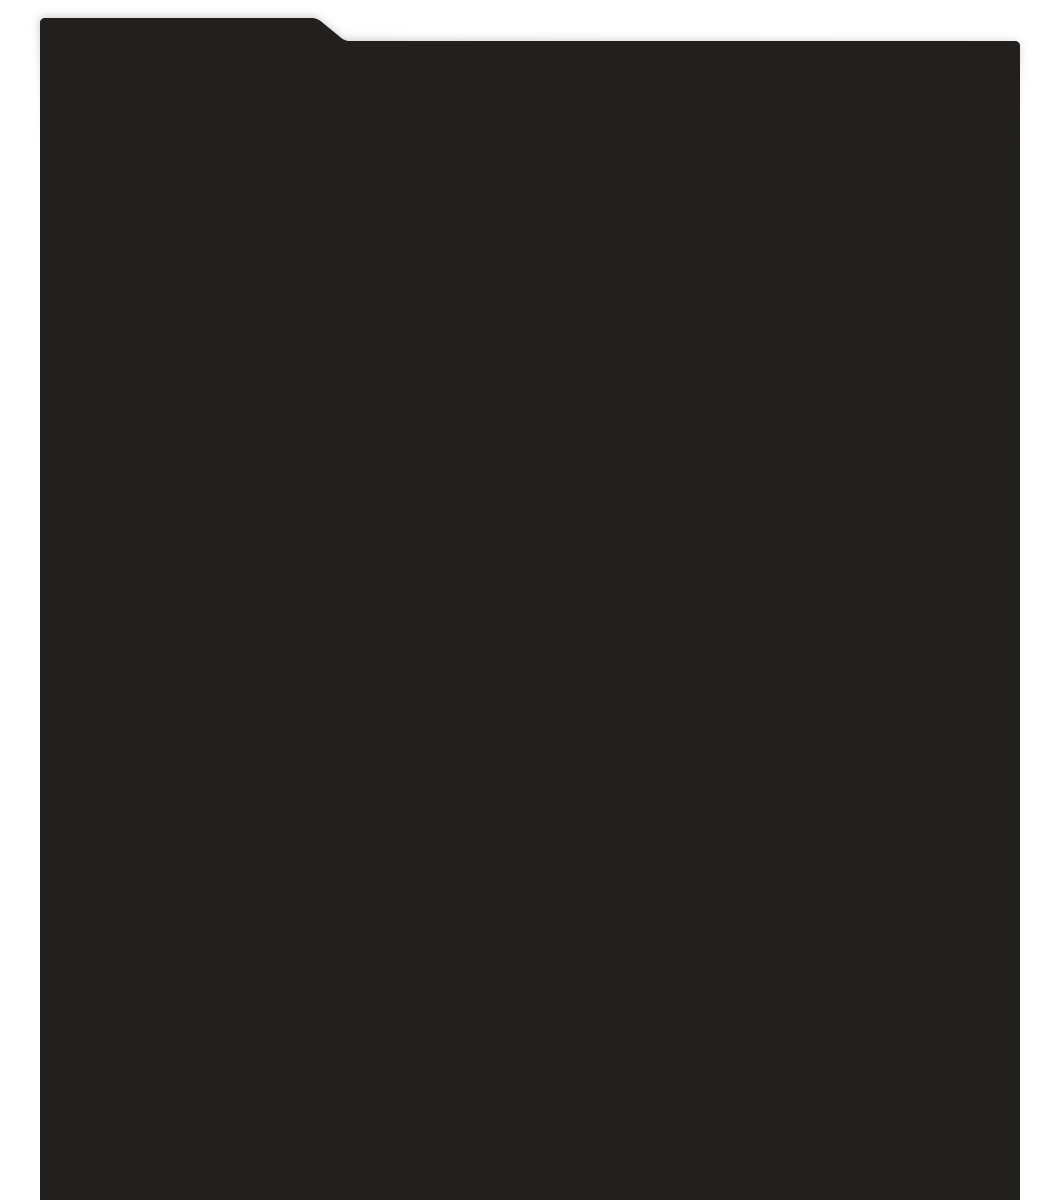
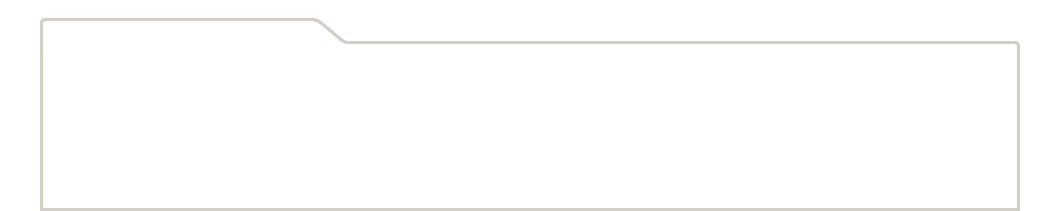
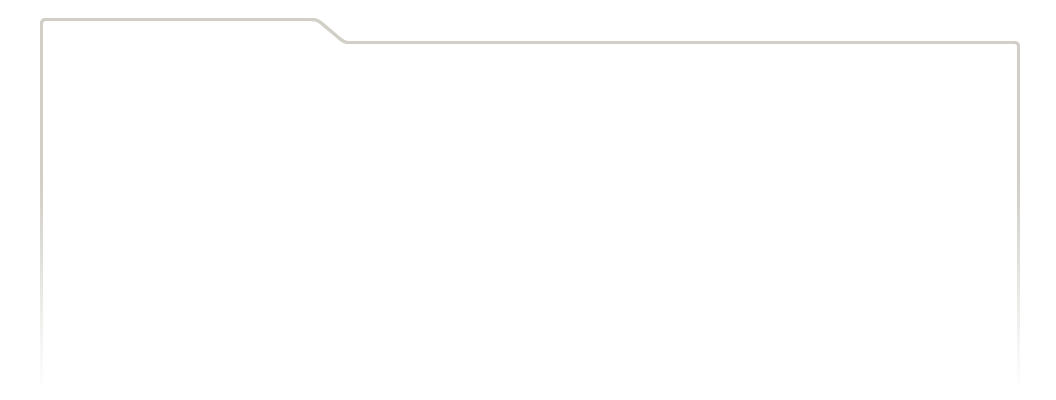
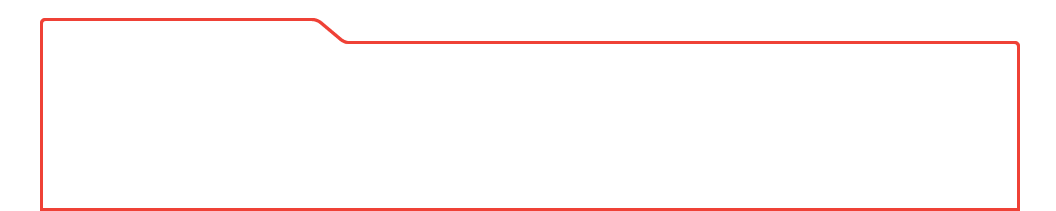
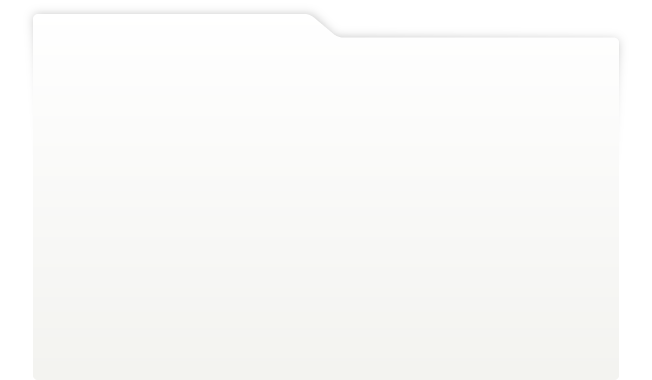
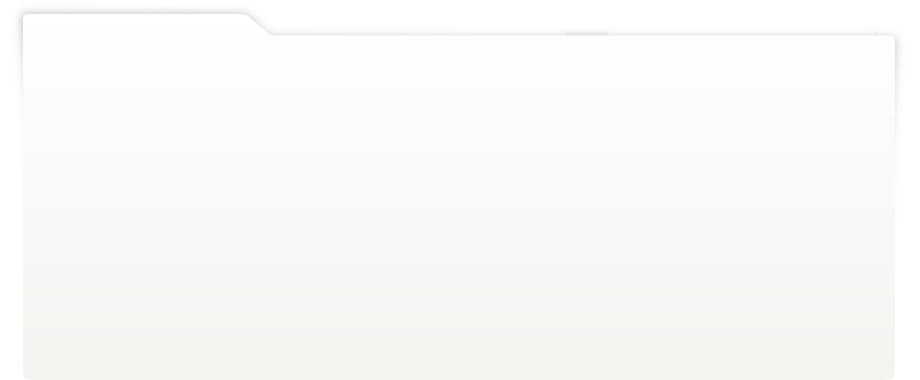
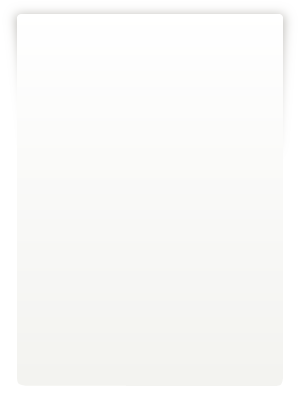
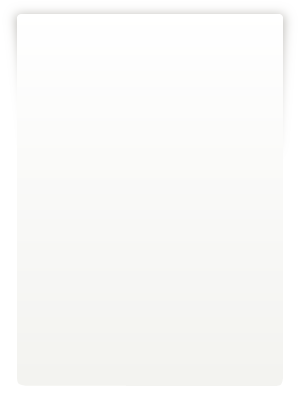
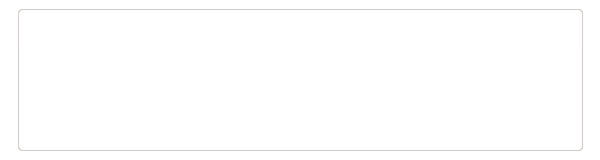
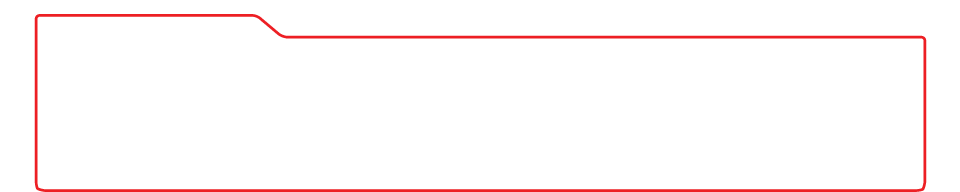
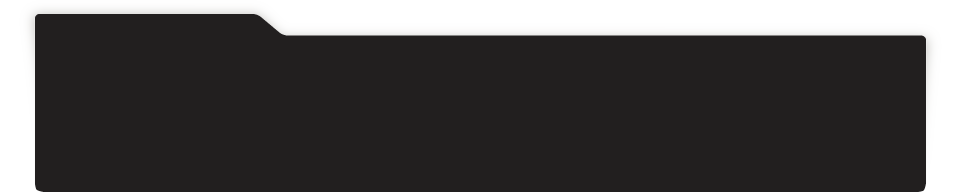
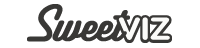
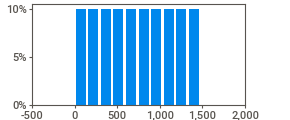
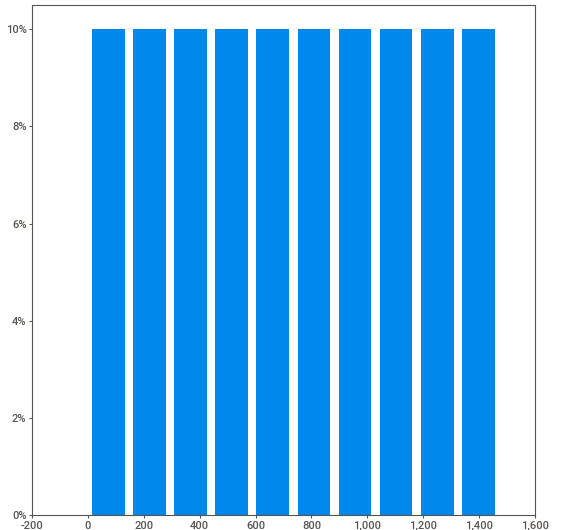
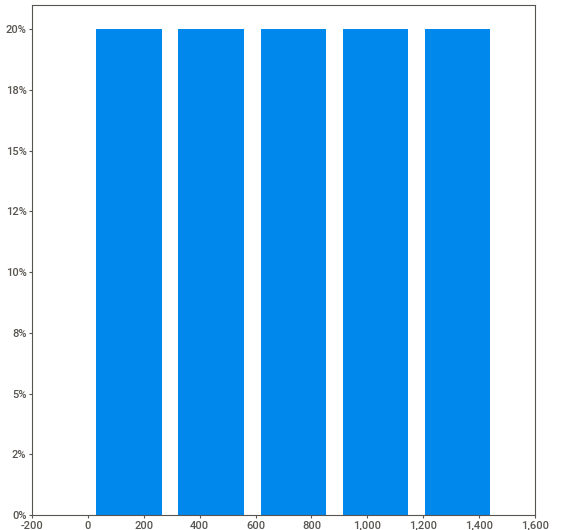
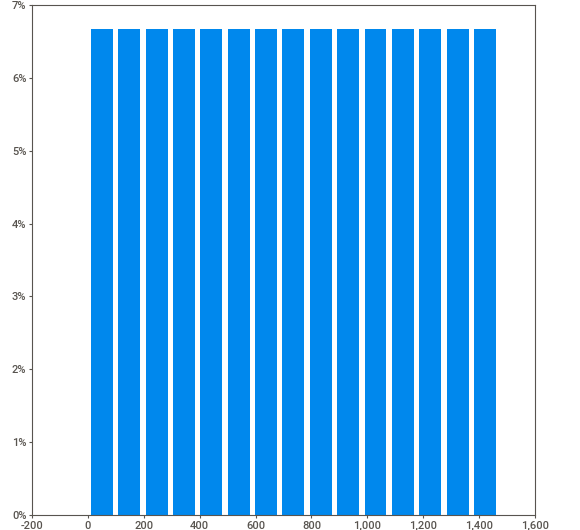
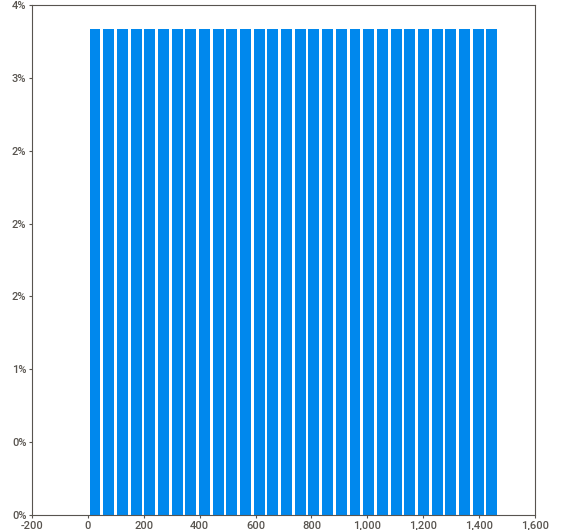
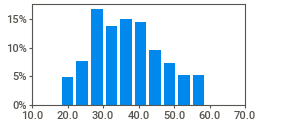
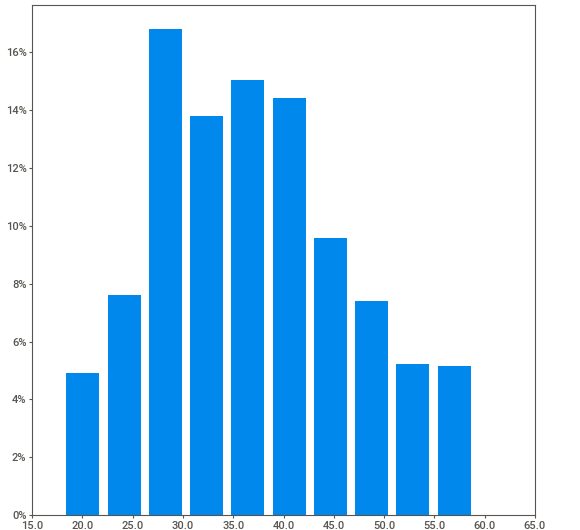
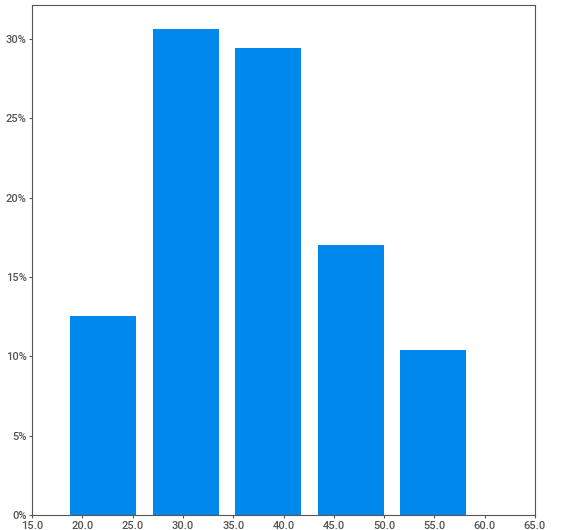
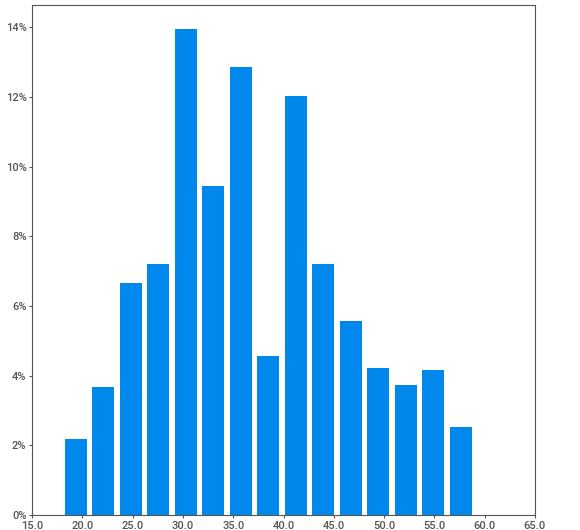
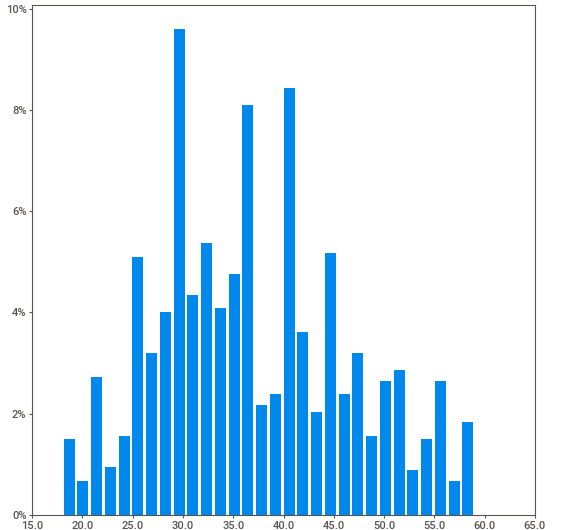
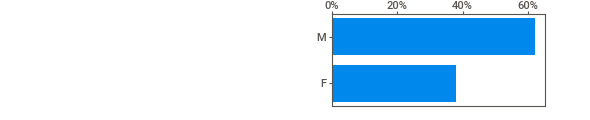
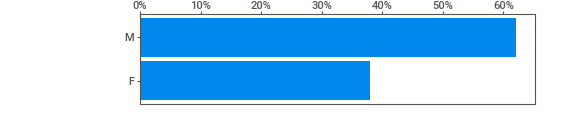
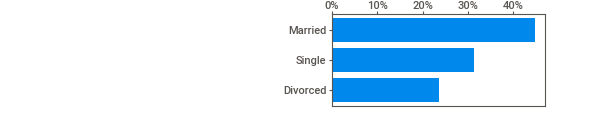
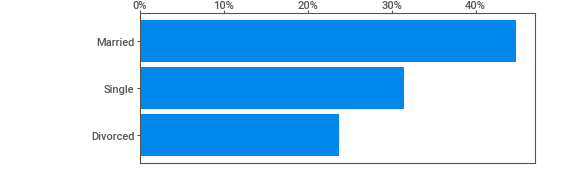
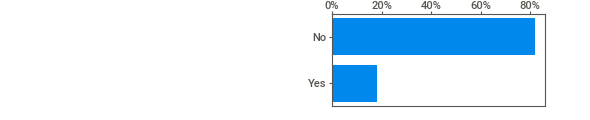
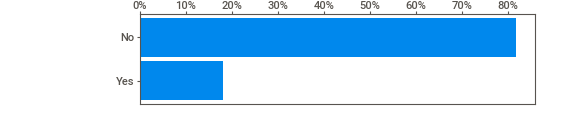
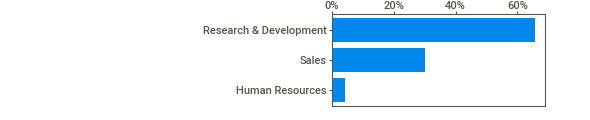
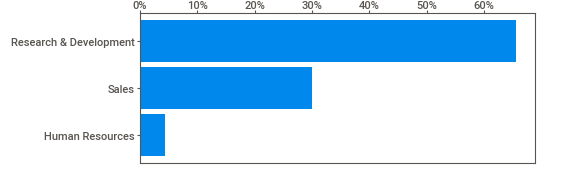
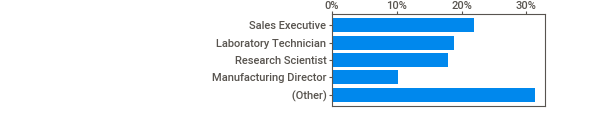
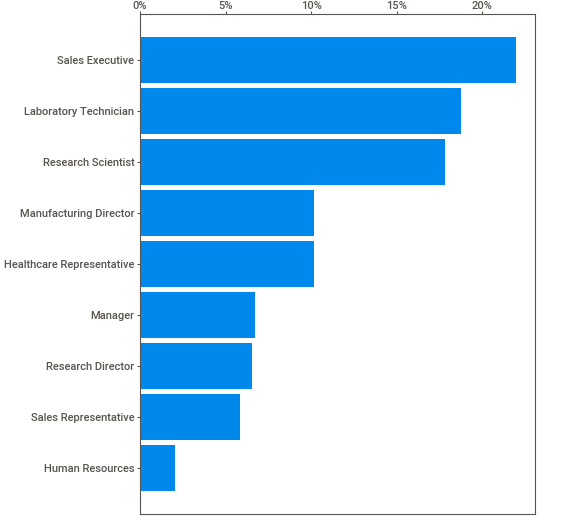
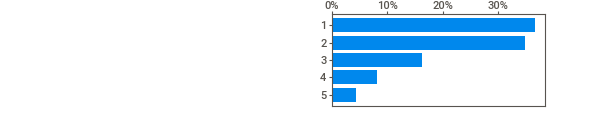
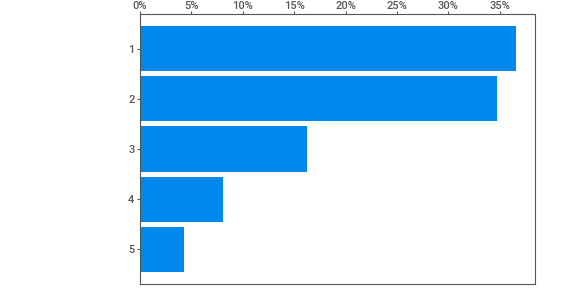
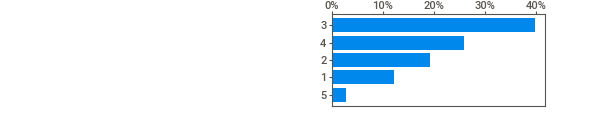
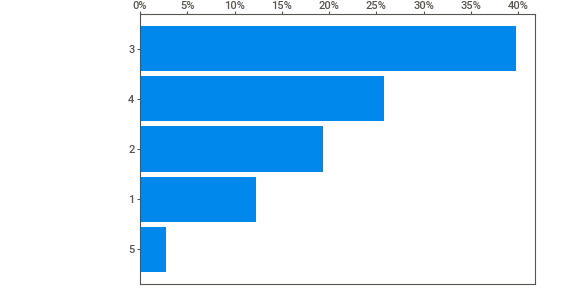
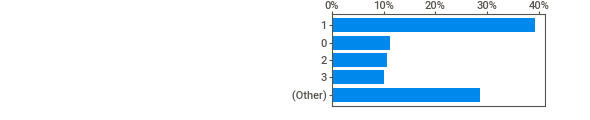
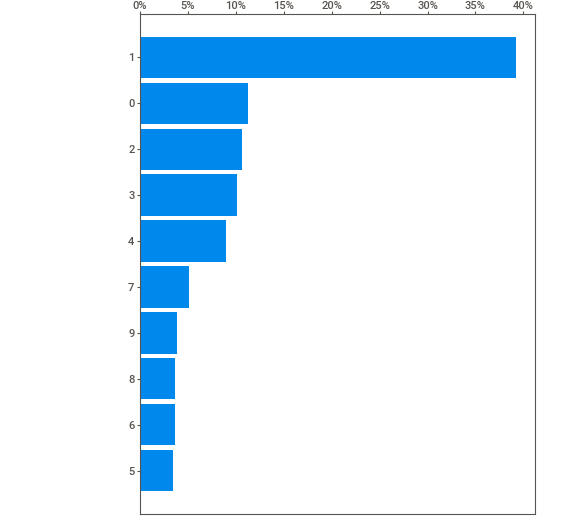
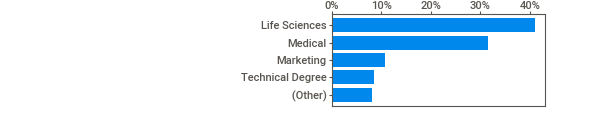
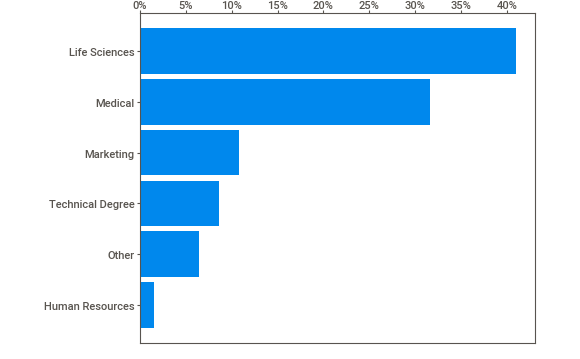
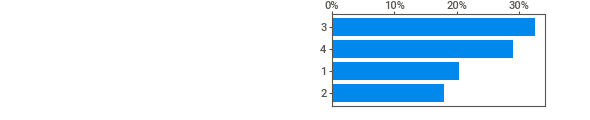
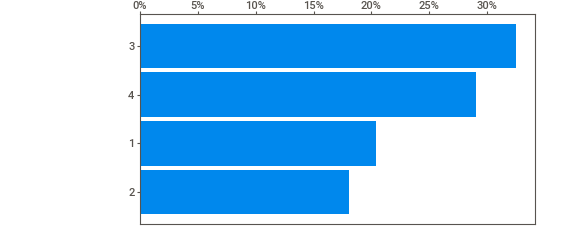
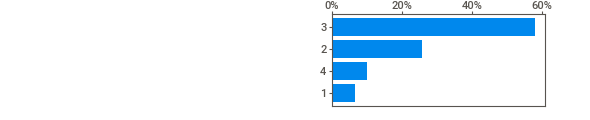
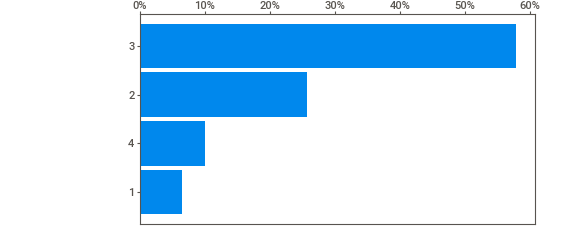
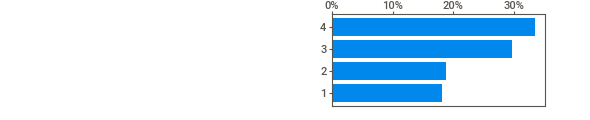
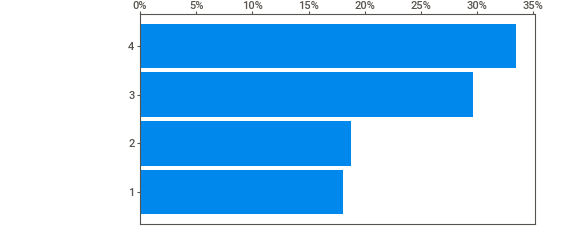
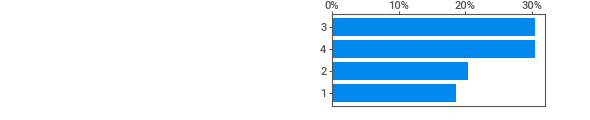
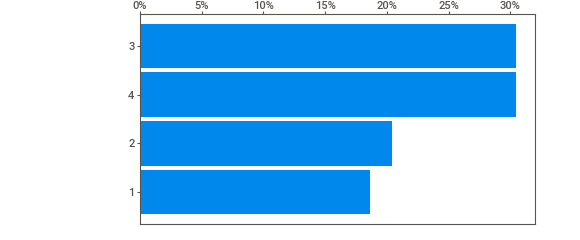
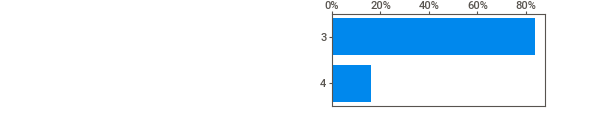
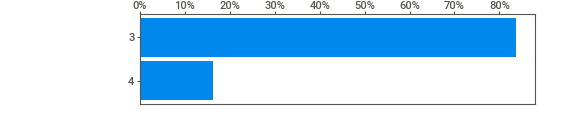
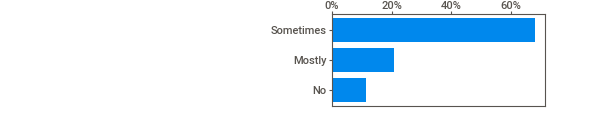
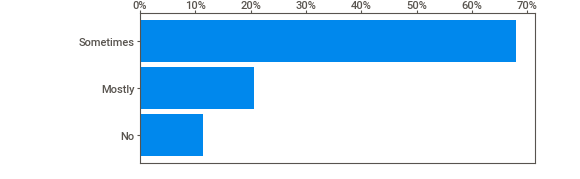
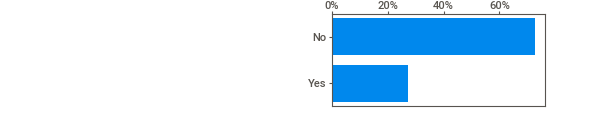
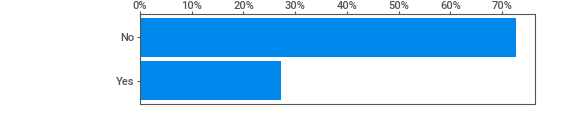
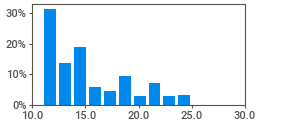
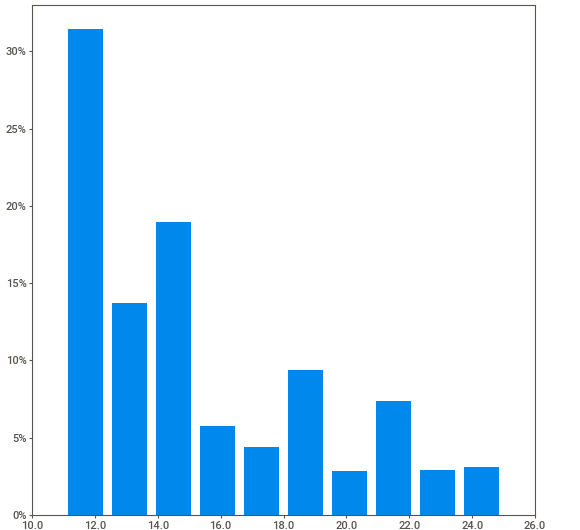
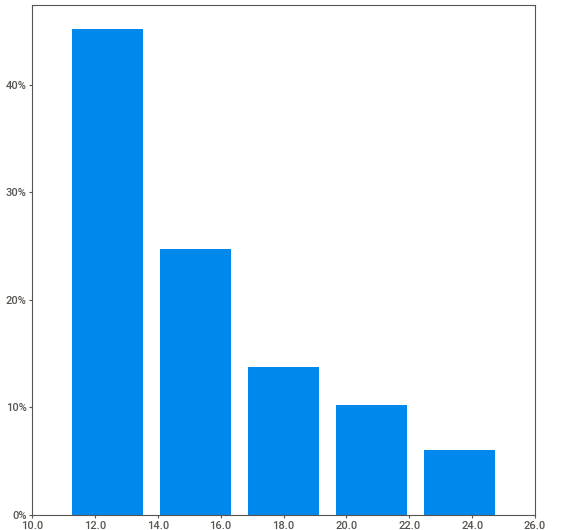
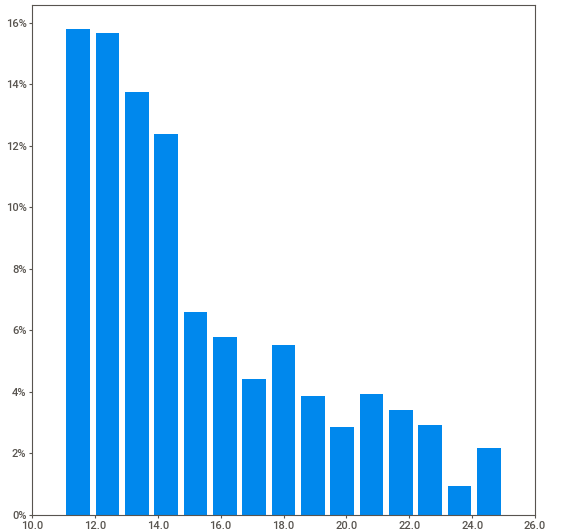
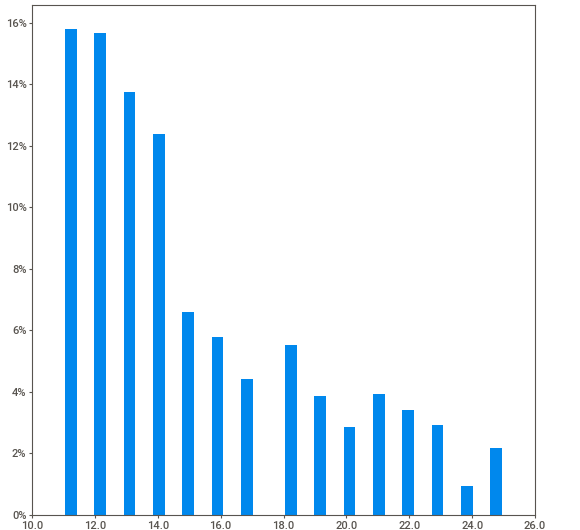
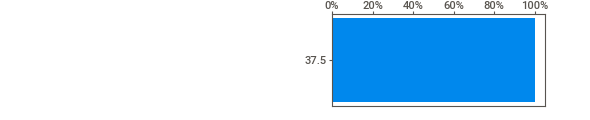
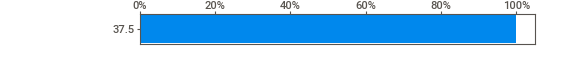
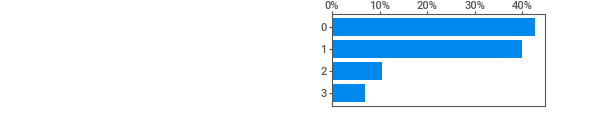
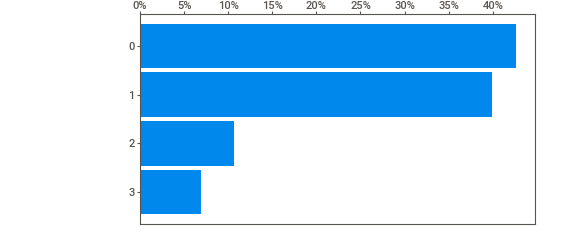
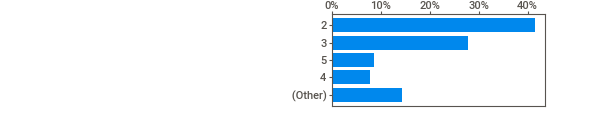
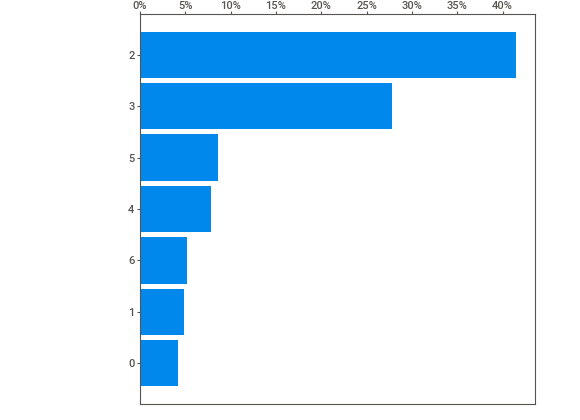
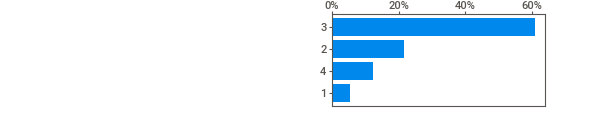
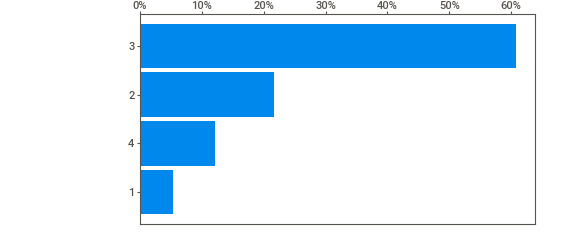
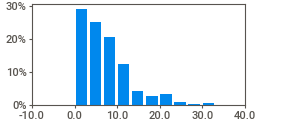
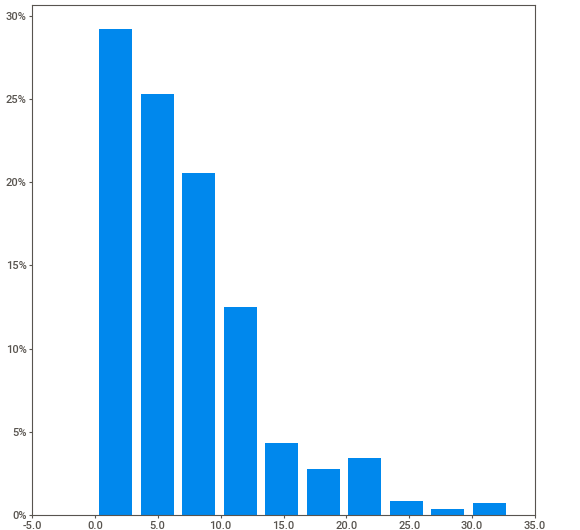
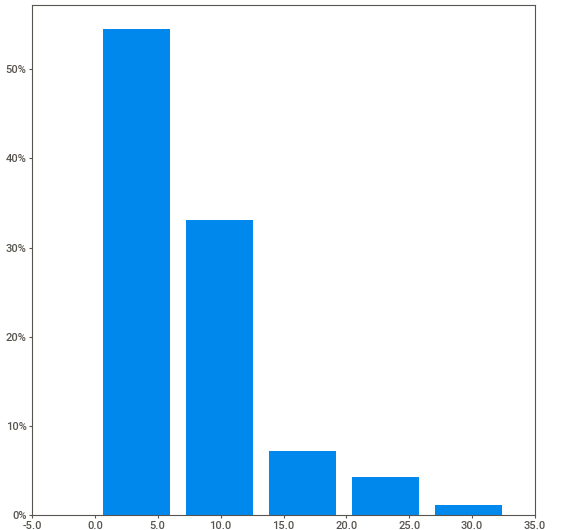
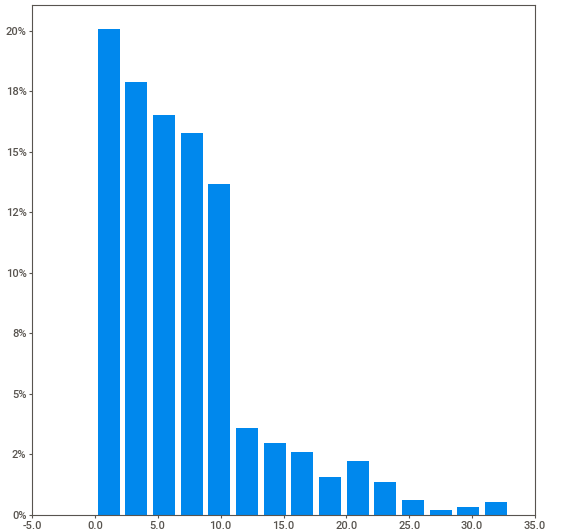
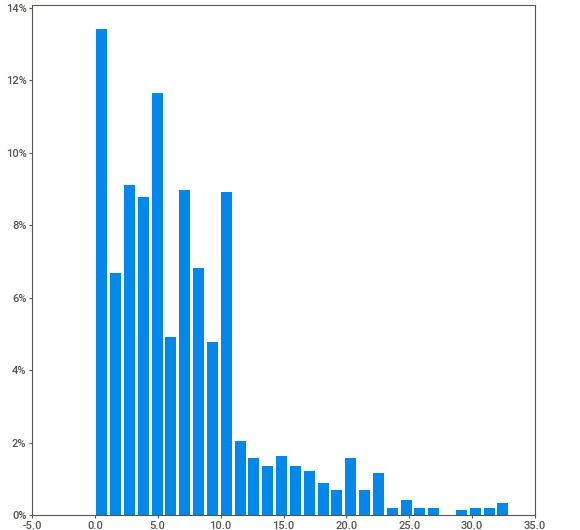
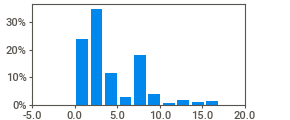
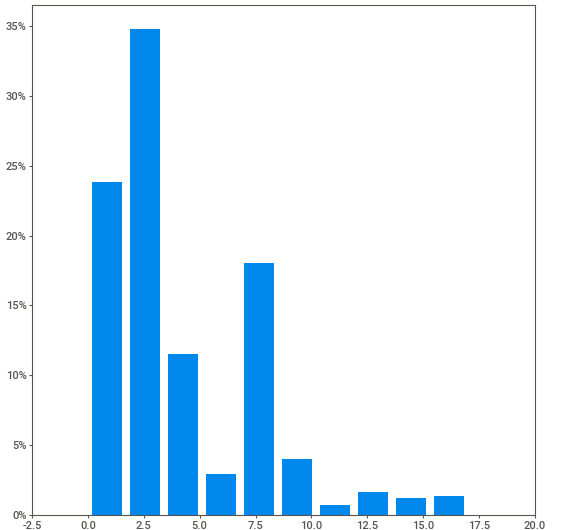
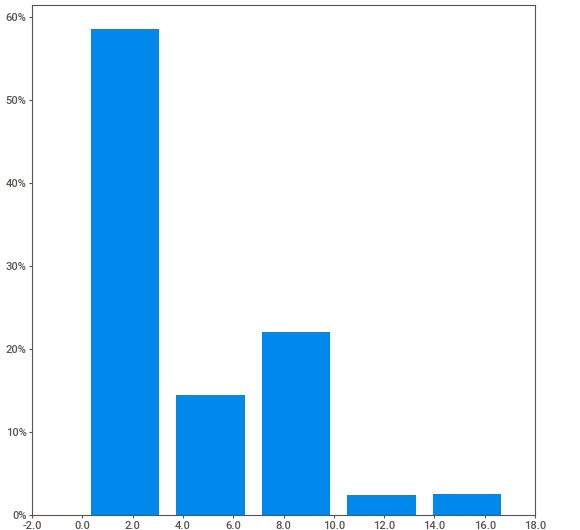
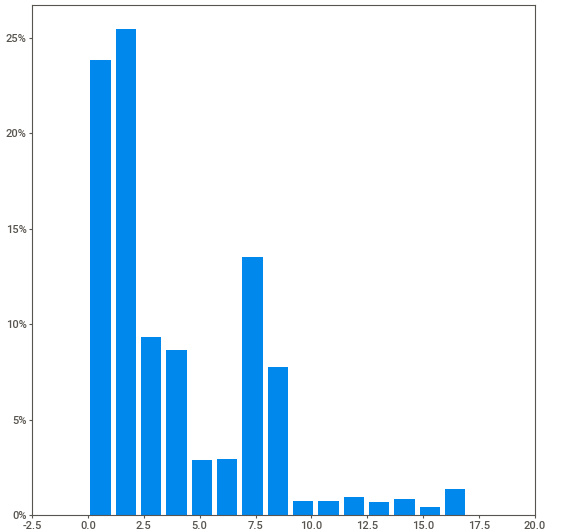
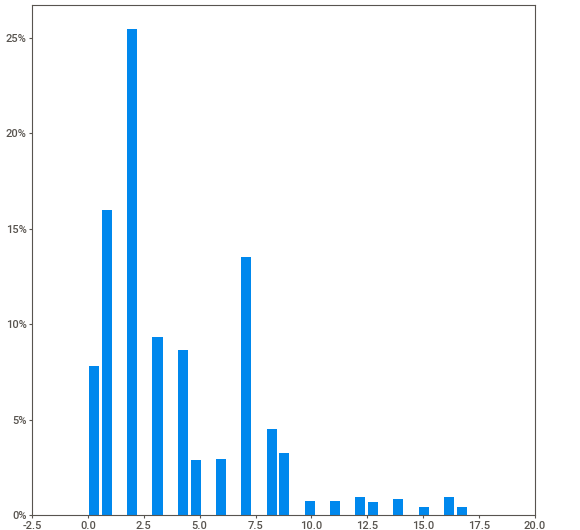
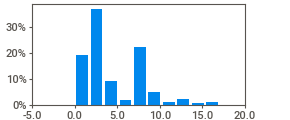
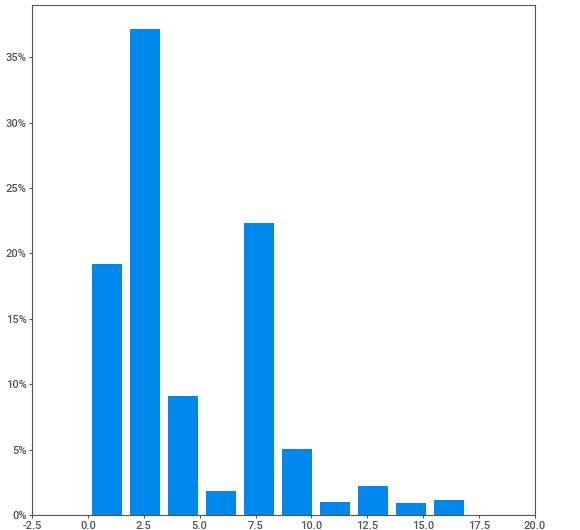
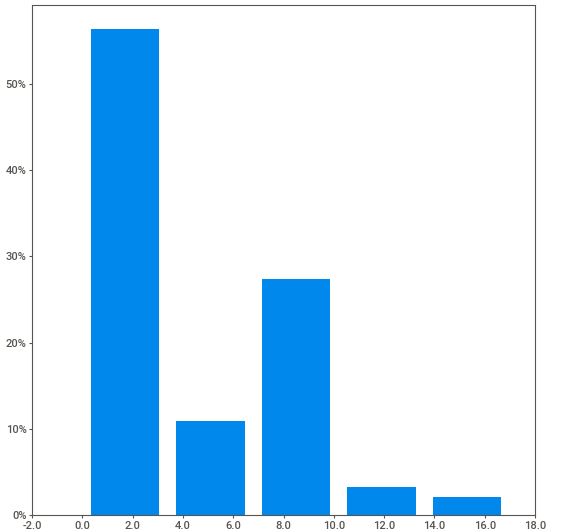
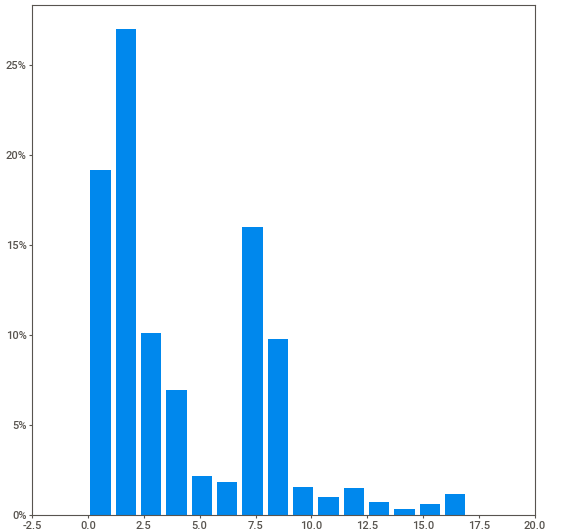
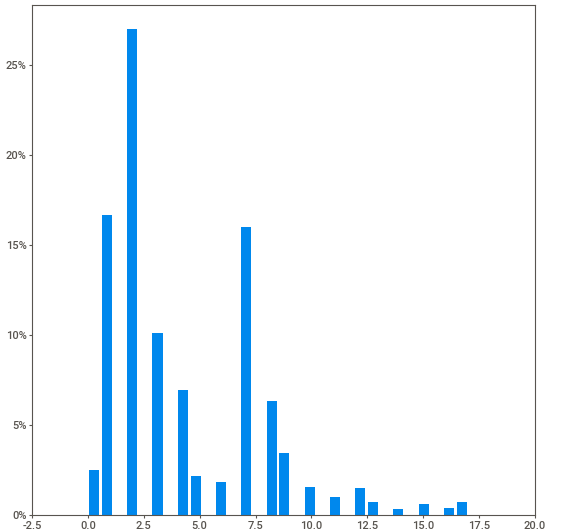
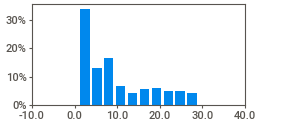
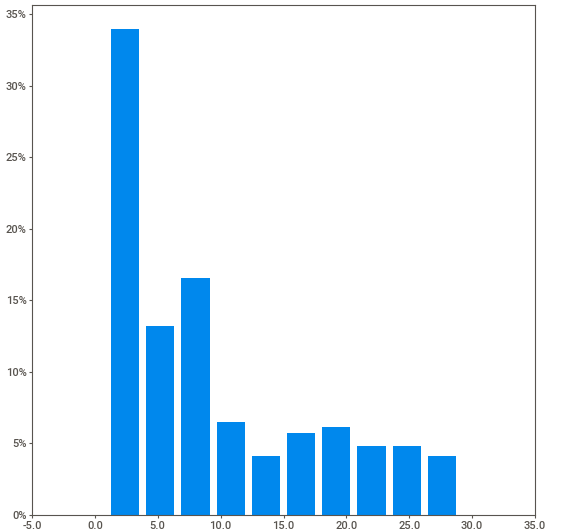
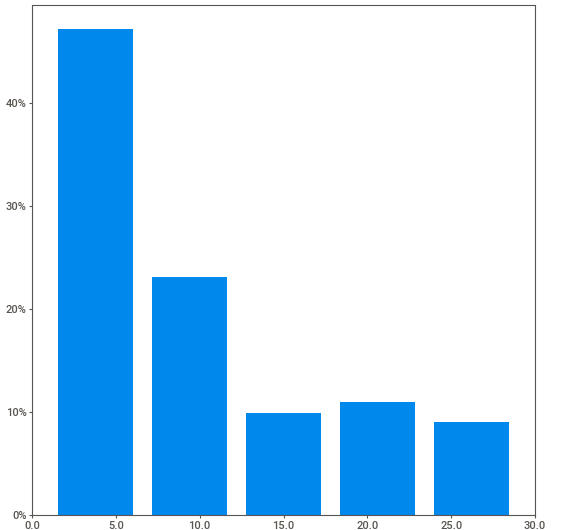
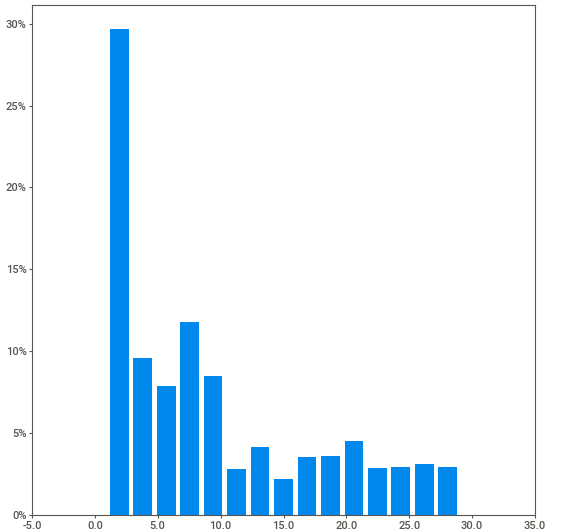
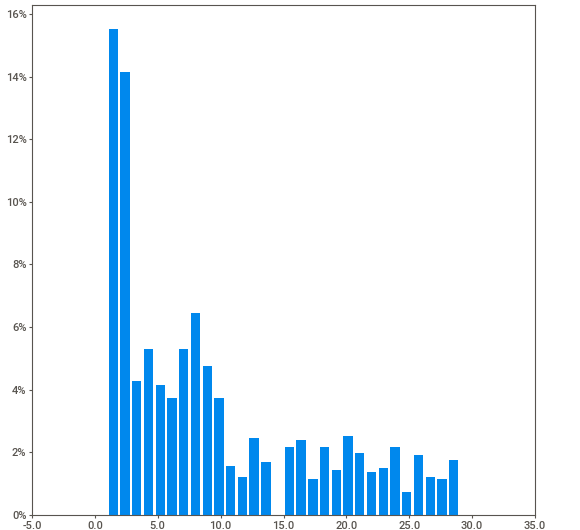

In [9]:
# Pairwise feature analysis involves comparing each feature in the dataset against every other feature to identify potential relationships and correlations between them. 
# 'Off' can be useful if you have a large dataset with many features, as pairwise analysis can be computationally intensive and may take longer to generate the analysis report

report = sv.analyze(df, pairwise_analysis='off')  

# displays the sweetviz info in the notebook cell below 

report.show_notebook()

In [10]:
# Describe non-numeric attributes
non_numeric_describe = df[categorical_cols].describe().transpose()

# Rename columns for better display
non_numeric_describe.rename(columns={'count': 'Count', 'unique': 'Unique', 'top': 'Top', 'freq': 'Frequency'}, inplace=True)

print(non_numeric_describe)

                 Count Unique                     Top Frequency
gender            1470      2                       M       913
marital_status    1470      3                 Married       659
turnover          1470      2                      No      1203
department        1470      3  Research & Development       965
role              1470      9         Sales Executive       323
education_field   1470      6           Life Sciences       603
traveling         1470      3               Sometimes       999
regular_overtime  1470      2                      No      1069


#### CATEGORICAL ATTRIBUTES

Firstly, when considering gender distribution, we observe a predominantly male composition, with 913 out of 1470 employees identifying as male, compared to 557 females. This gender imbalance is noteworthy and may warrant further investigation into our recruitment and diversity initiatives.

In terms of marital status, a significant proportion of our employees are married, with 659 individuals in this category. This finding suggests that family dynamics and responsibilities may play a substantial role in our employees' lives and could impact their engagement and satisfaction at work.

Exploring turnover within our organisation, we find that 1203 employees are currently employed ('No' turnover status), while 267 are ex-employees ('Yes' turnover status). This indicates a turnover rate of approximately 18%, underscoring the importance of understanding factors contributing to employee attrition and retention.

When examining departmental distribution, the majority of our employees (965 out of 1470) are situated within the Research & Development department, indicating a strong focus on innovation and product development within our organisation.

In terms of job roles, the most prevalent role is 'Sales Executive', with 323 employees occupying this position. This suggests a significant emphasis on sales and client relations within our company.

Regarding education background, the majority of our workforce has a background in 'Life Sciences' (603 employees), followed by other fields such as 'Medical', 'Technical Degree', and 'Marketing'.

Considering work-related factors, nearly all employees (999 out of 1470) report 'Sometimes' engaging in travel as part of their job responsibilities. Additionally, the majority of employees (1069 out of 1470) do not engage in regular overtime work.

These findings provide valuable insights into the composition and dynamics of our workforce, highlighting areas of strength as well as potential challenges that warrant attention and strategic intervention.

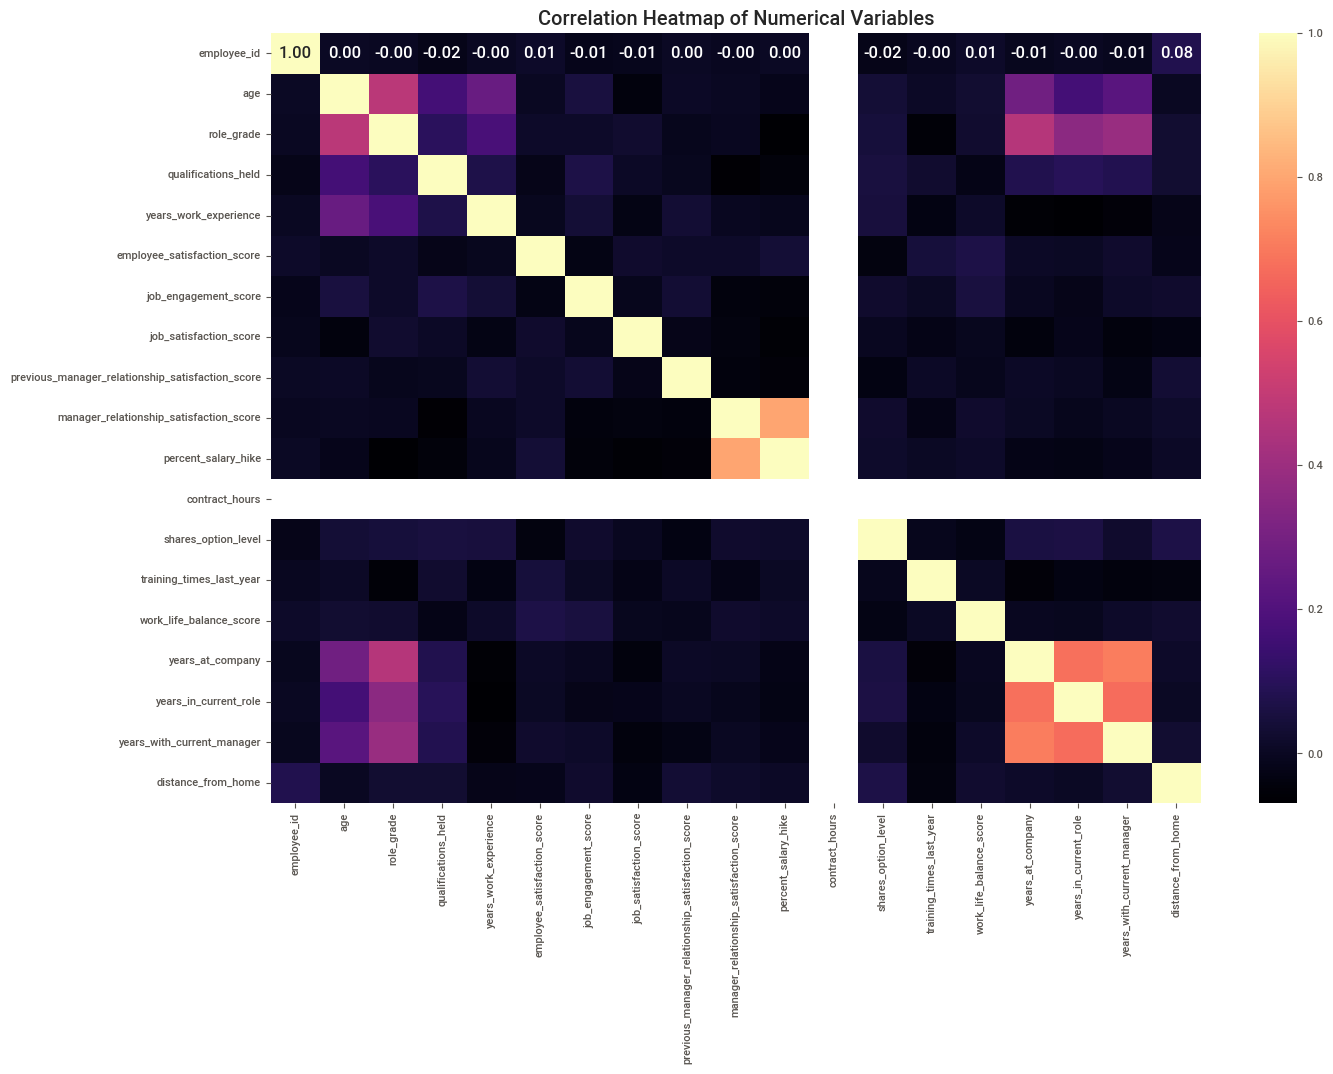

In [11]:
# Visualise relationships between numerical variables

plt.figure(figsize=(15, 10))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='magma', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

In [12]:
# lets check the descriptive statistics of the dataset to gain some insight into numerical attributes distributions & central tendencies
print("\nSummary statistics:")
df.describe()


Summary statistics:


,employee_id,age,role_grade,qualifications_held,years_work_experience,employee_satisfaction_score,job_engagement_score,job_satisfaction_score,previous_manager_relationship_satisfaction_score,manager_relationship_satisfaction_score,percent_salary_hike,contract_hours,shares_option_level,training_times_last_year,work_life_balance_score,years_at_company,years_in_current_role,years_with_current_manager,distance_from_home
count,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00
mean,735.50,37.07,2.09,2.88,2.66,2.70,2.71,2.79,2.73,3.16,15.12,37.50,0.82,2.77,2.80,7.07,3.97,4.32,9.28
std,424.50,9.52,1.11,1.02,2.50,1.10,0.73,1.10,1.09,0.37,3.82,0.00,0.88,1.35,0.71,5.75,3.45,3.46,8.16
min,1.00,18.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,3.00,11.00,37.50,0.00,0.00,1.00,0.00,0.00,0.00,1.00
25%,368.25,30.00,1.00,2.00,1.00,2.00,2.00,2.00,2.00,3.00,12.00,37.50,0.00,2.00,2.00,3.00,2.00,2.00,2.00
50%,735.50,36.00,2.00,3.00,1.00,3.00,3.00,3.00,3.00,3.00,14.00,37.50,1.00,2.00,3.00,6.00,3.00,3.00,7.00
75%,1102.75,44.00,3.00,4.00,4.00,4.00,3.00,4.00,4.00,3.00,18.00,37.50,1.00,3.00,3.00,9.00,7.00,7.00,15.00
max,1470.00,59.00,5.00,5.00,9.00,4.00,4.00,4.00,4.00,4.00,25.00,37.50,3.00,6.00,4.00,33.00,17.00,17.00,29.00



#### NUMERICAL ATTRIBUTES

Based on the descriptive statistics generated from df.describe(), the following insights are apparent:

**Employee Age:** The average age of employees at Company X is approximately 37 years, with a standard deviation of around 9.52 years, indicating a moderate level of diversity in age within the workforce. The age range spans from 18 to 59 years, with the majority falling between 30 and 44 years old.

**Qualifications:** Employee qualifications range from 1 to 5, with an average qualification level of about 2.88. The variability in qualifications, as suggested by the standard deviation, highlights the diverse skill sets present among our employees.

**Employee Satisfaction and Engagement:** Satisfaction and engagement levels range from 1 to 4, with mean scores of approximately 2.70 and 2.71, respectively. This variation in scores reflects the diverse perspectives and attitudes among our workforce.

**Job Level and Job Satisfaction:** Job levels range from 1 to 5, with an average level of approximately 2.09. Similarly, job satisfaction scores vary from 1 to 4, with a mean score of about 2.79. This diversity in job levels and satisfaction underscores the unique career paths and experiences of our employees.

**Manager Relationship Score:** Unlike the previous year, where scores exhibited more diversity, this year's scores predominantly cluster around 3 or 4 for all employees. This pattern may suggest a potential concern regarding the perceived anonymity of the survey, leading to safer, more neutral responses.

**Work Experience and Tenure:** Employees have varying levels of work experience, with mean values indicating around 6 to 7 years of experience. The duration of employment, both overall and within specific roles, shows moderate to high variability. Notably, most employees have tenure ranging from 1 to 10 years, with a decline observed beyond this range, possibly indicating turnover or career stagnation. Regarding promotions, a majority of the workforce (at least 1000 employees) received promotions within the last 2 years, reflecting a recent emphasis on career advancement opportunities within the company.

**Distance From Home:** Commuting distances range from 1 to 29 miles, with a mean distance of approximately 9.28 miles. The variability in distances reflects 

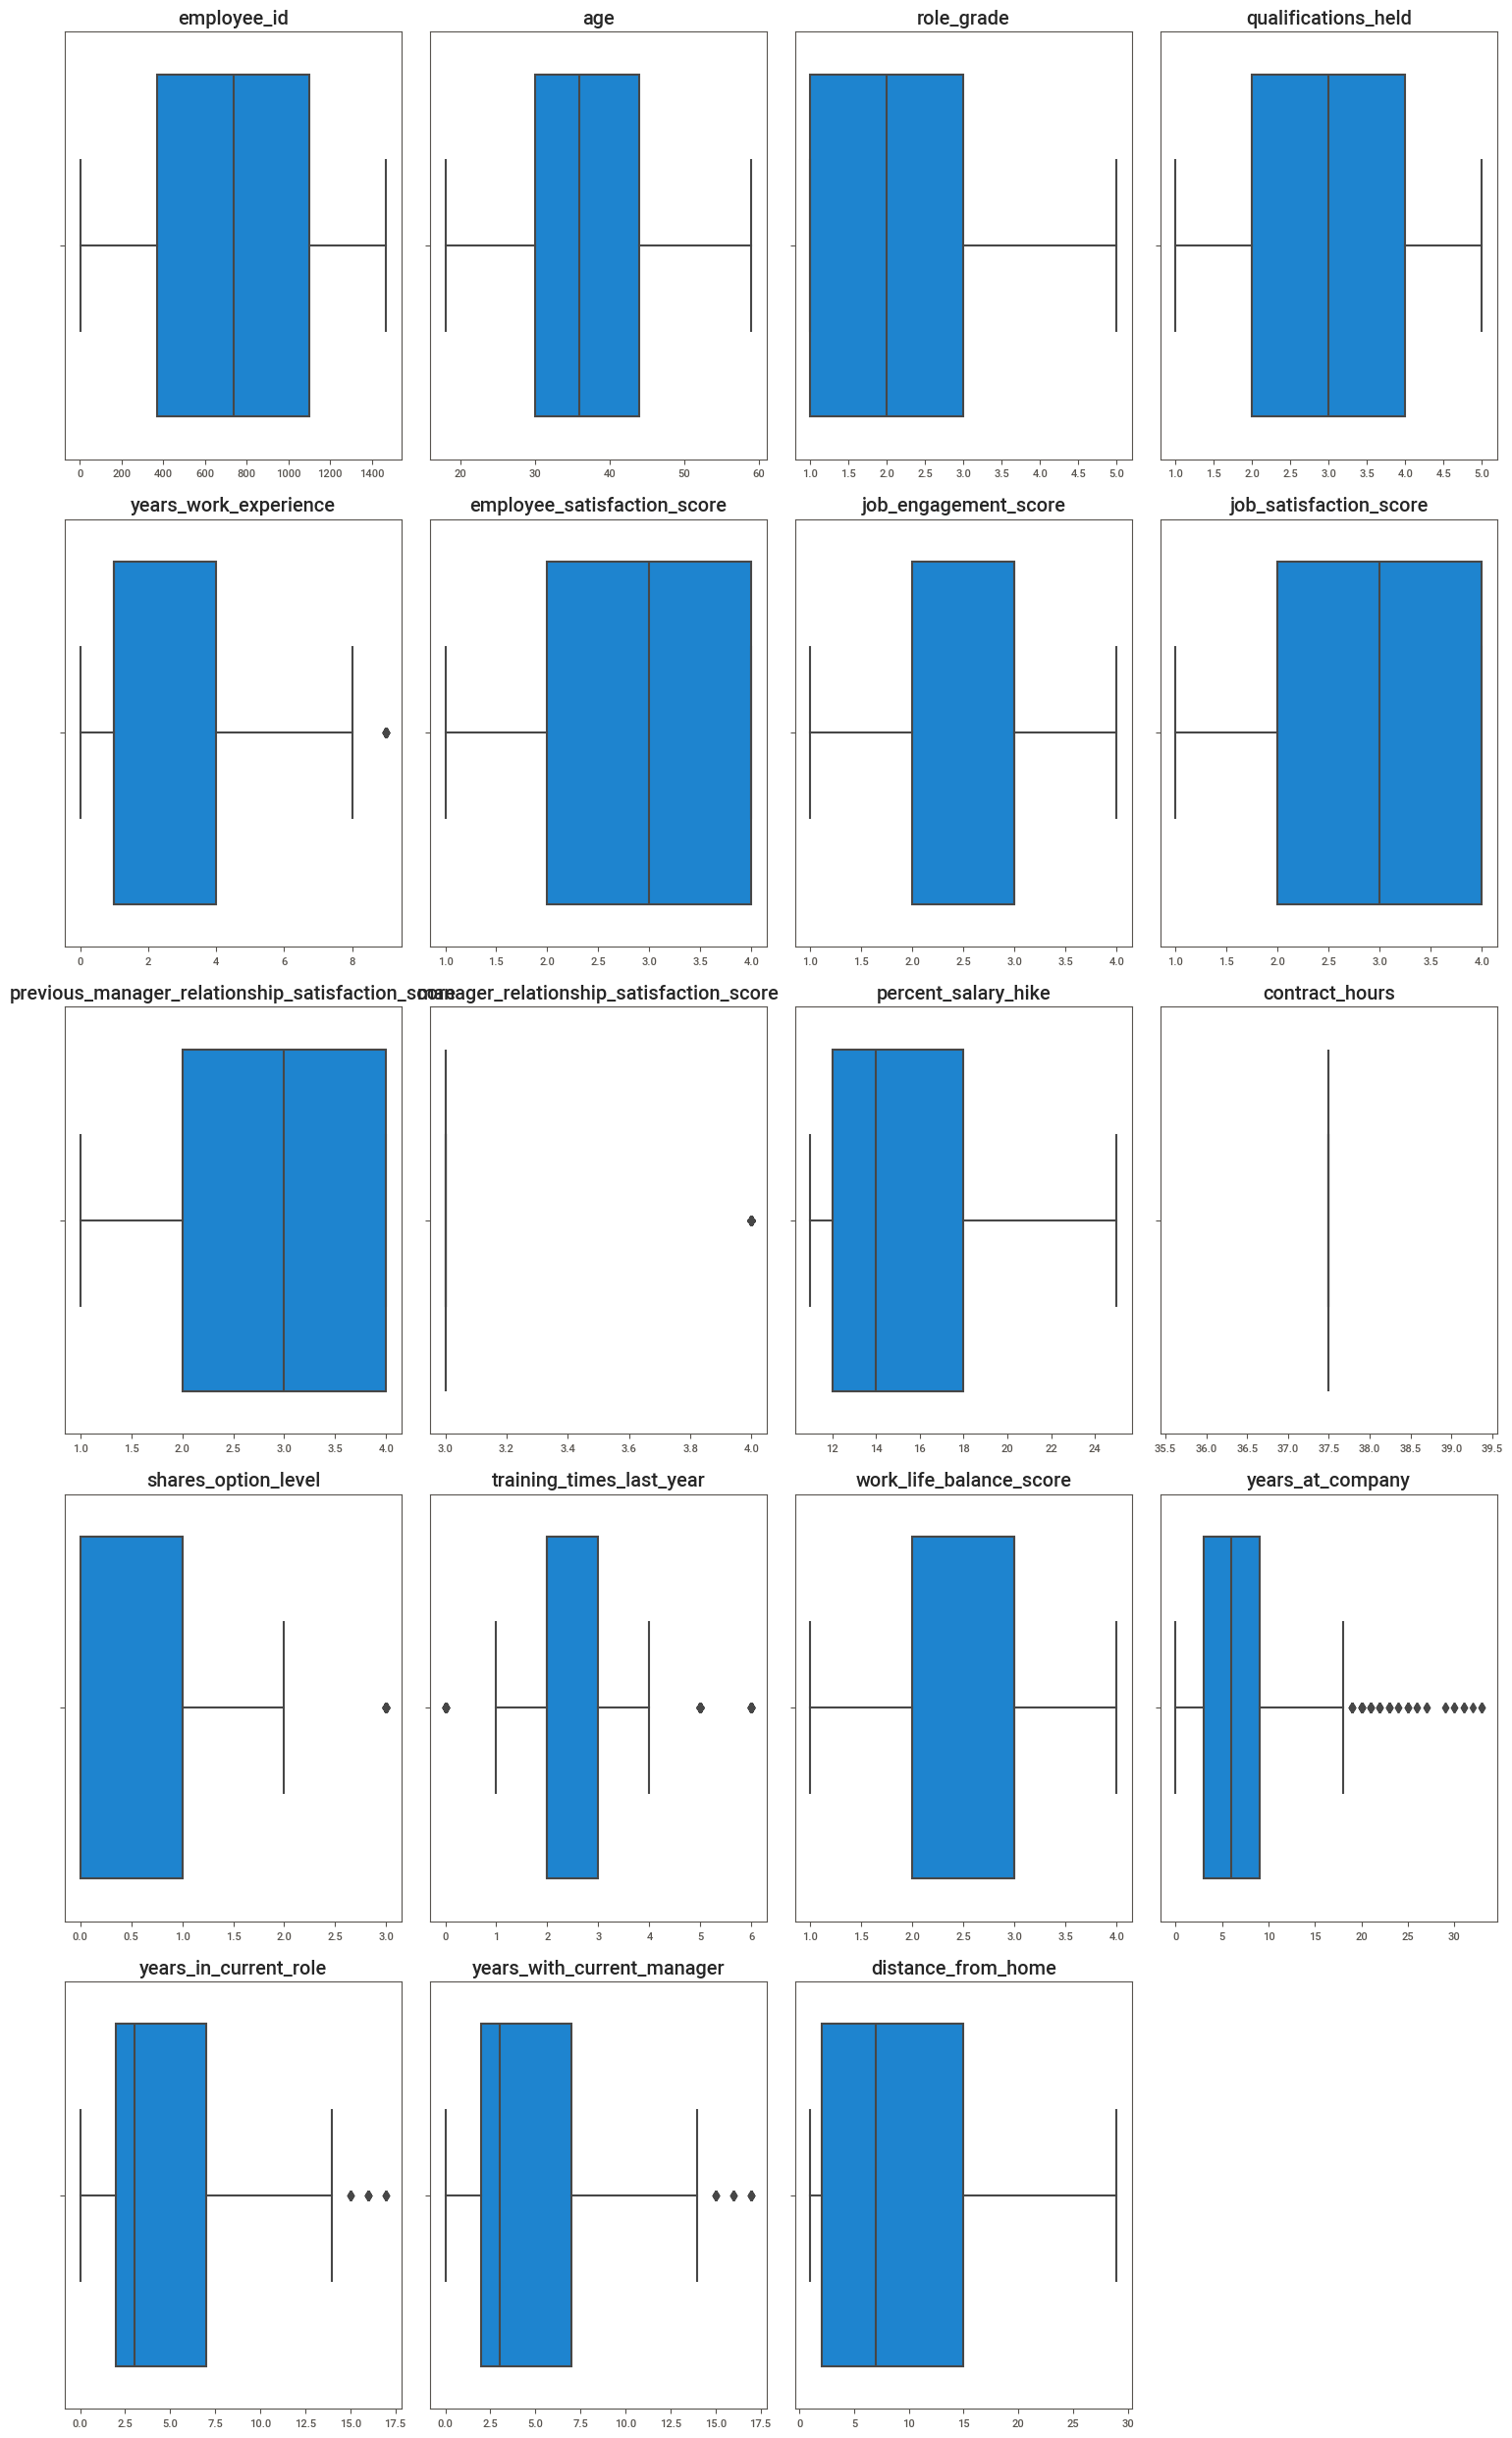

In [13]:
# let's visualise the distribution with box plots for each attribute 

def boxplot_for_each_attribute(df, numerical_cols):
    # Calculate the number of rows needed for the subplots
    num_rows = (len(numerical_cols) + 1) // 4
    
    # Set the size of the plot
    plt.figure(figsize=(15, 5 * num_rows))
    
    # Loop through each numeric column specified
    for i, column in enumerate(numerical_cols):
        # Create a box plot for the current attribute
        plt.subplot(num_rows, 4, i + 1)
        sns.boxplot(x=df[column])
        plt.title(column)
        plt.xlabel('')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the function with your dataset and numerical_cols variable
boxplot_for_each_attribute(df, numerical_cols)

In [14]:
def detect_outliers(df):
    """
    Detect outliers in each numeric column of the dataframe.
    Outliers are defined as values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR.
    """
    numeric_cols = df.select_dtypes(include=[np.number])
    for col in numeric_cols:
        # Calculate Q1, Q3, and IQR
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        # Identify outliers
        outliers = df[(df[col] <= q1 - 1.5 * iqr) | (df[col] >= q3 + 1.5 * iqr)]
        perc = len(outliers) * 100.0 / len(df)
        # Print column summary
        print(f"Column: {col}")
        print(f"Min: {df[col].min()}, Max: {df[col].max()}")
        print(f"Outliers: {len(outliers)} ({perc:.2f}%)")
        if not outliers.empty:
            print("Outlier values:", outliers[col].values)
        print("-----")

detect_outliers(df)

Column: employee_id
Min: 1, Max: 1470
Outliers: 0 (0.00%)
-----
Column: age
Min: 18, Max: 59
Outliers: 0 (0.00%)
-----
Column: role_grade
Min: 1, Max: 5
Outliers: 0 (0.00%)
-----
Column: qualifications_held
Min: 1, Max: 5
Outliers: 0 (0.00%)
-----
Column: years_work_experience
Min: 0, Max: 9
Outliers: 57 (3.88%)
Outlier values: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
-----
Column: employee_satisfaction_score
Min: 1, Max: 4
Outliers: 0 (0.00%)
-----
Column: job_engagement_score
Min: 1, Max: 4
Outliers: 0 (0.00%)
-----
Column: job_satisfaction_score
Min: 1, Max: 4
Outliers: 0 (0.00%)
-----
Column: previous_manager_relationship_satisfaction_score
Min: 1, Max: 4
Outliers: 0 (0.00%)
-----
Column: manager_relationship_satisfaction_score
Min: 3, Max: 4
Outliers: 1470 (100.00%)
Outlier values: [3 3 4 ... 3 4 3]
-----
Column: percent_salary_hike
Min: 11, Max: 25
Outliers: 0 (0.00%)
-----
Column: contract_hours
Min: 37.

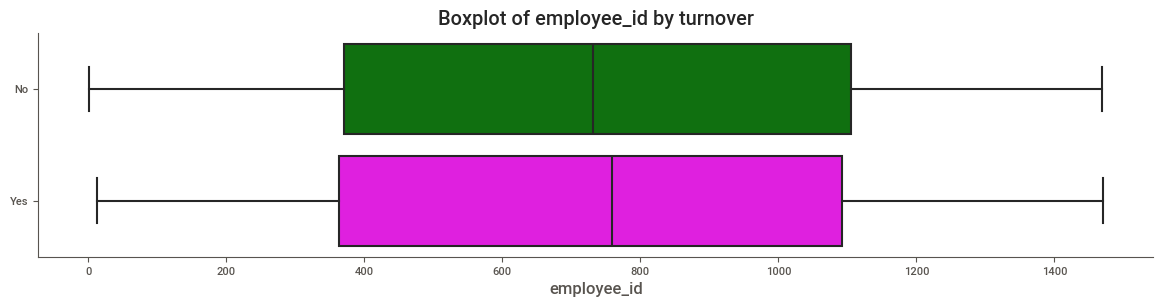

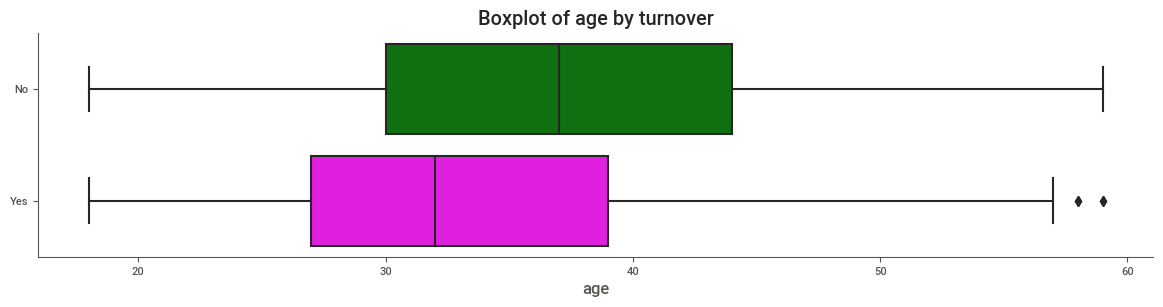

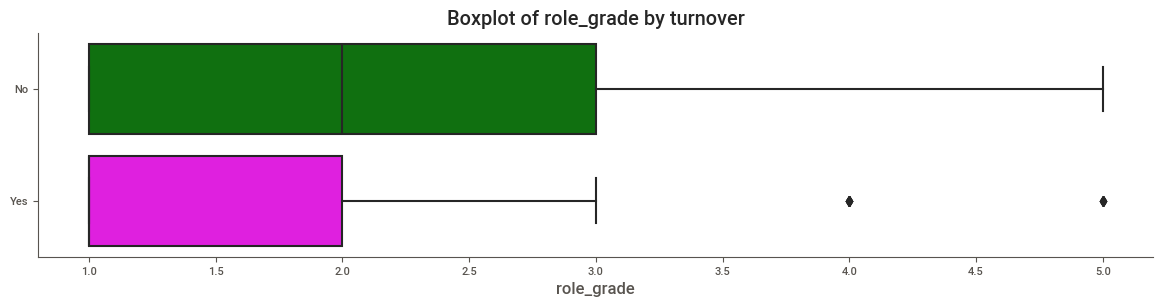

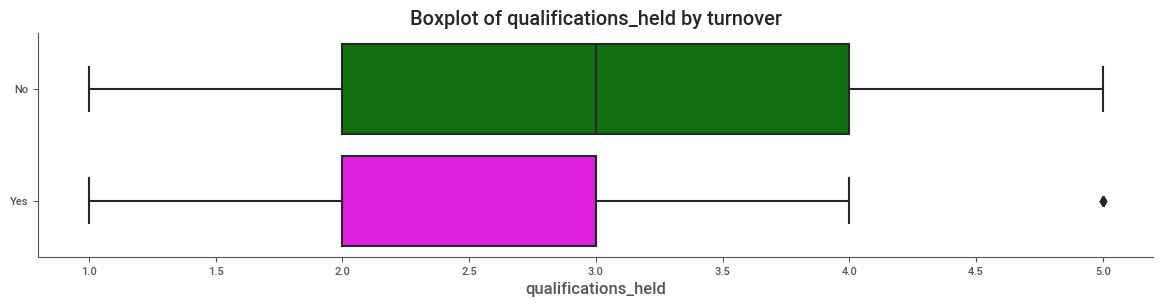

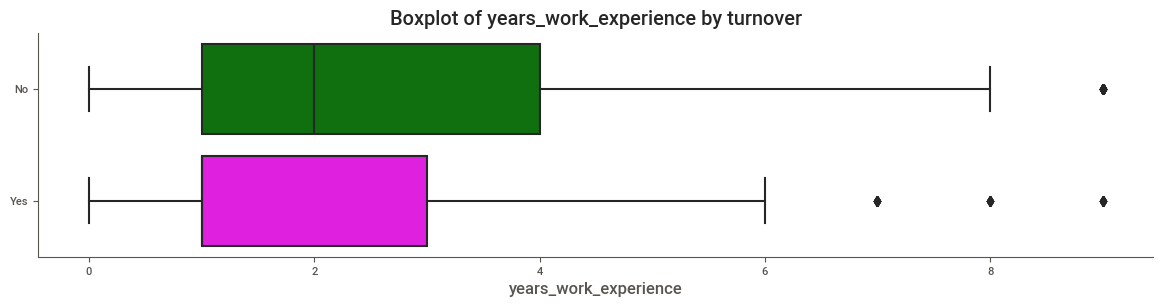

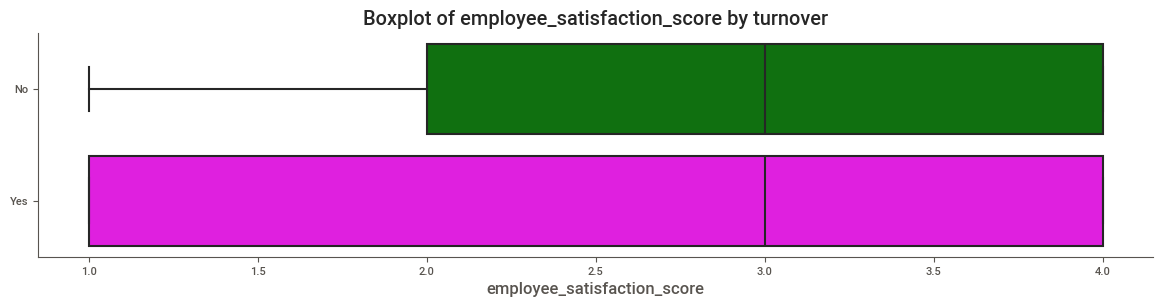

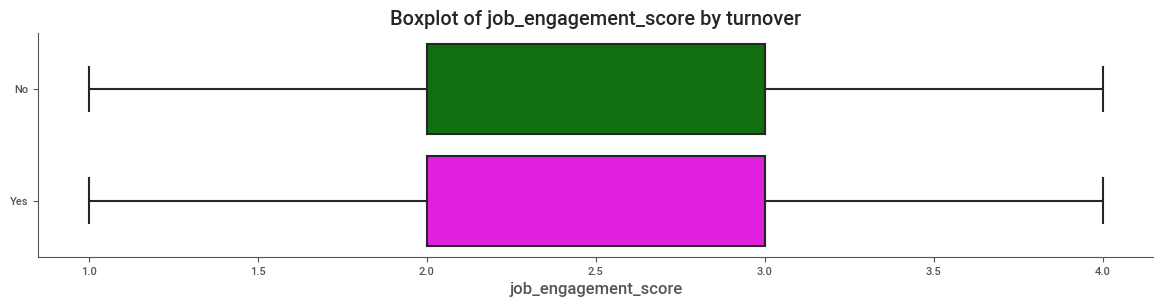

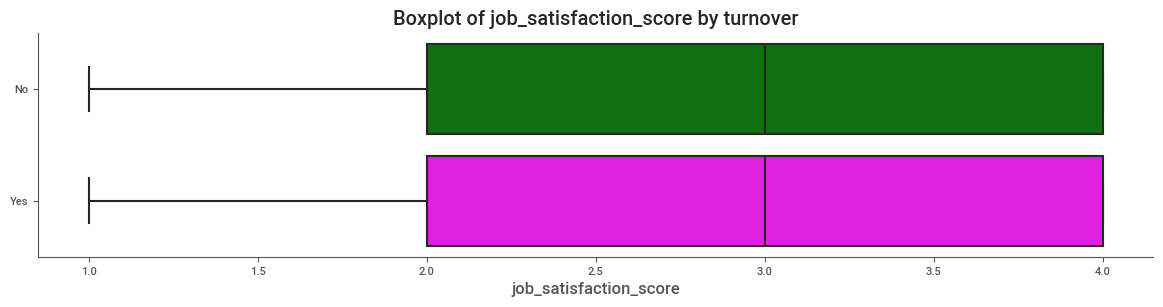

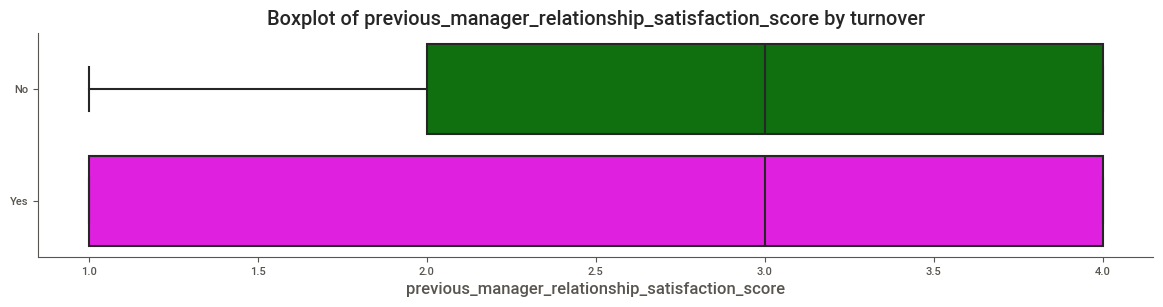

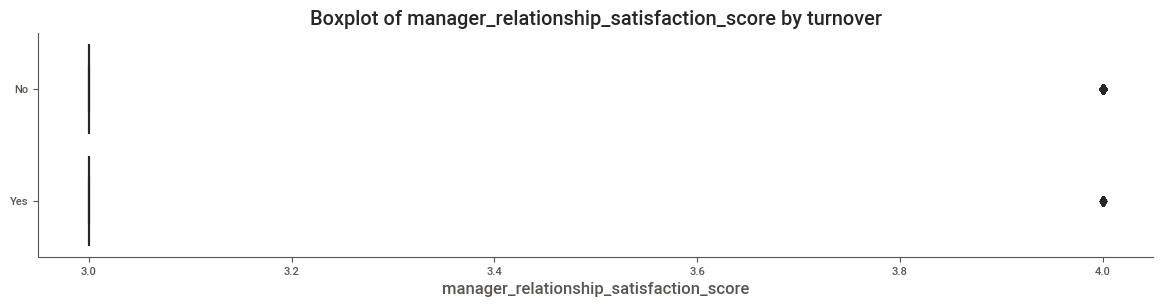

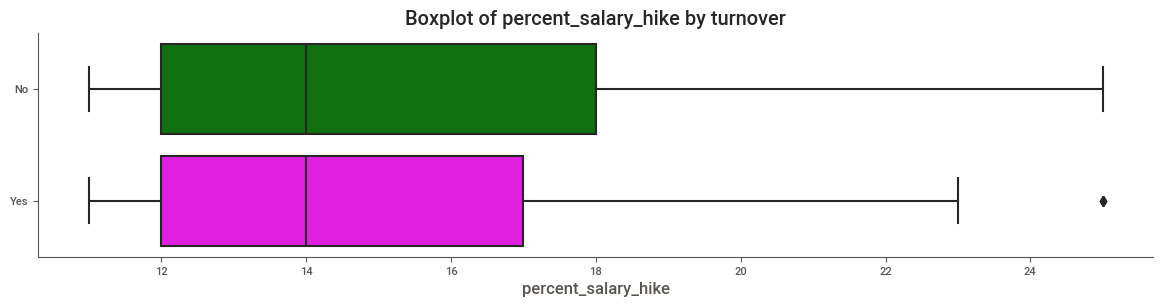

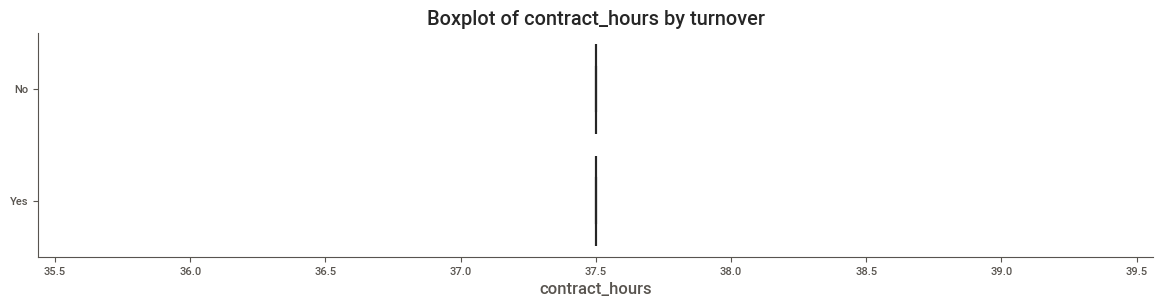

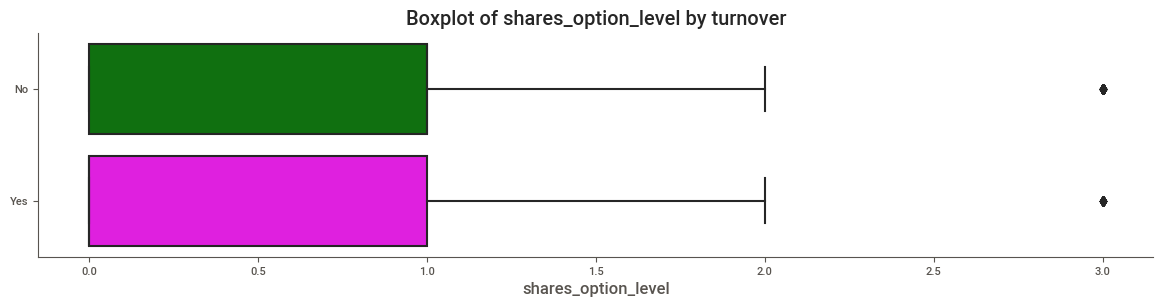

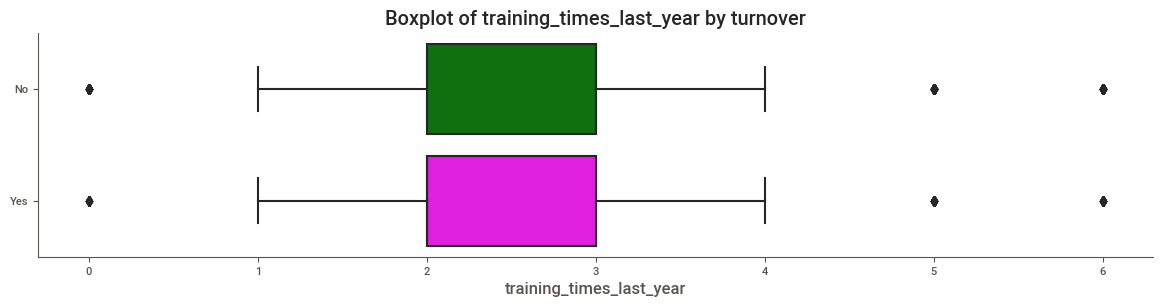

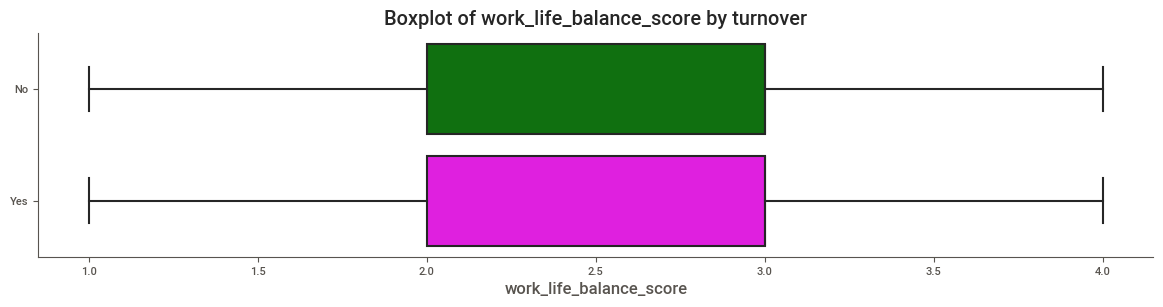

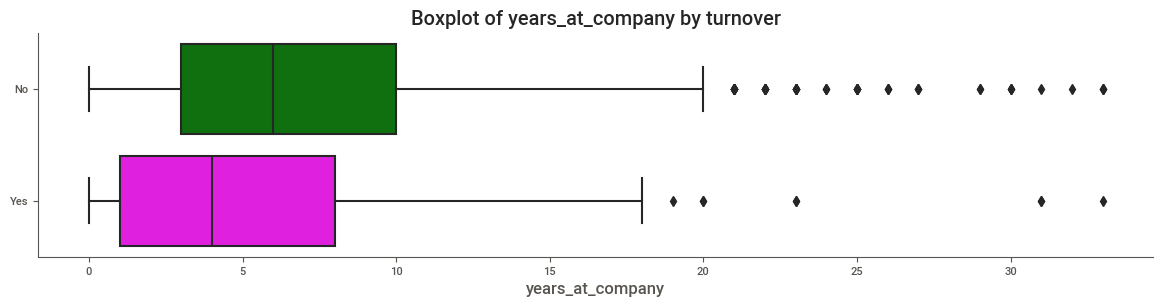

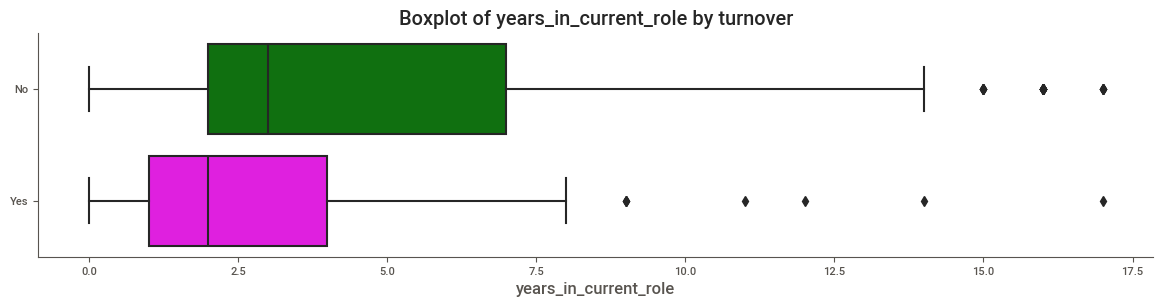

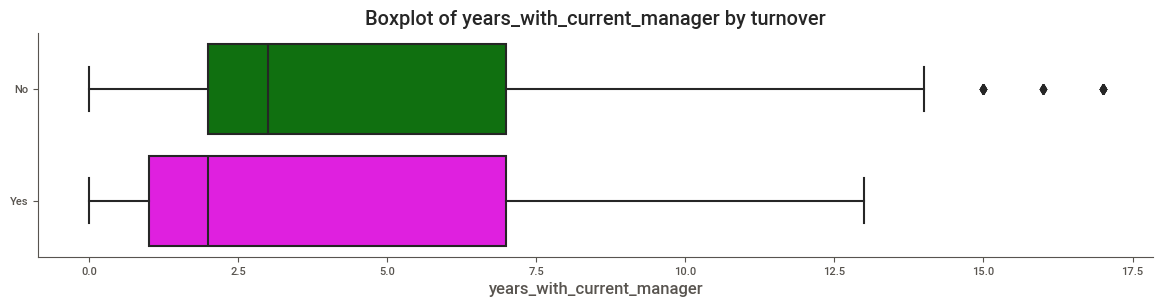

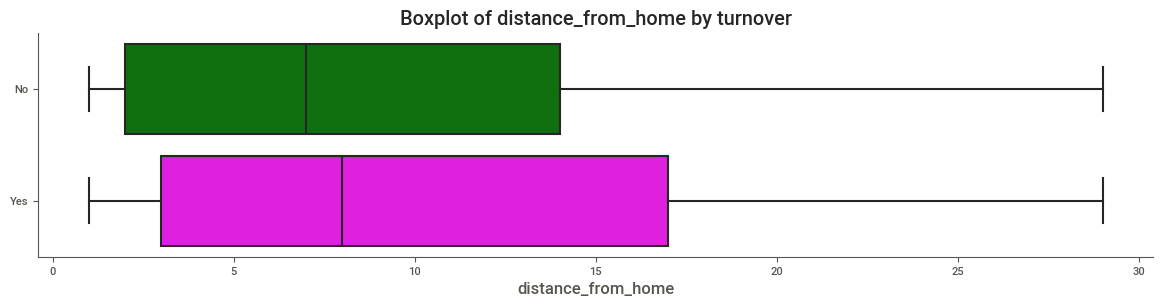

In [15]:
# outlier visualisation

def visual_outliers(df, cat_outcome):
    # Get unique categories in the 'cat_outcome' variable
    unique_categories = df[cat_outcome].unique()

    # Define colors for each category
    colors = ['green', 'magenta']  # Example colors, you can customize this

    # Create a dictionary mapping each category to its corresponding color
    color_dict = {category: color for category, color in zip(unique_categories, colors)}

    for col in df.select_dtypes(include=[np.number]):
        g = sns.catplot(
            data=df,
            x=col, y=cat_outcome,
            kind="box", orient="h",
            sharex=False, margin_titles=True,
            height=3, aspect=4,
            palette=color_dict, 
        )
        g.set(xlabel="{}".format(col), ylabel="")
        plt.title("Boxplot of {} by {}".format(col, cat_outcome))
        plt.show()

visual_outliers(df, "turnover")



In [16]:
# drop columns we don't need
df.drop(columns=['employee_id', 'contract_hours'], inplace=True)

In [17]:
# target variable to binary

df['turnover'] = df['turnover'].replace({'No': 0, 'Yes': 1}).astype(int)

df.head(5)

,age,gender,marital_status,turnover,department,role,role_grade,qualifications_held,years_work_experience,education_field,...,traveling,regular_overtime,percent_salary_hike,shares_option_level,training_times_last_year,work_life_balance_score,years_at_company,years_in_current_role,years_with_current_manager,distance_from_home
0,46,F,Divorced,0,Research & Development,Manager,3,3,0,Medical,...,No,No,14,0,3,4,25,16,13,4
1,35,M,Divorced,0,Research & Development,Manufacturing Director,2,4,2,Life Sciences,...,Mostly,Yes,16,1,2,3,7,1,1,10
2,29,M,Single,0,Sales,Sales Representative,1,3,2,Life Sciences,...,Sometimes,No,21,0,2,1,3,1,2,2
3,26,M,Divorced,0,Sales,Sales Representative,1,3,7,Life Sciences,...,Sometimes,No,19,1,3,3,4,1,1,1
4,41,F,Single,0,Research & Development,Healthcare Representative,2,2,1,Life Sciences,...,Sometimes,No,14,0,3,3,10,7,7,2


In [18]:
#By using stratify=y, you're telling scikit-learn to split the data while maintaining the same proportion of classes as in the original dataset. 
#This helps prevent biased splits, especially in cases where one class is significantly smaller than the other, as in your case with the imbalance 
#between current and ex-employees.

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42,
                                     stratify=df['turnover'])

print(df_train['turnover'].value_counts(normalize=True))
print(df_test['turnover'].value_counts(normalize=True))

turnover
0   0.82
1   0.18
Name: proportion, dtype: float64
turnover
0   0.82
1   0.18
Name: proportion, dtype: float64


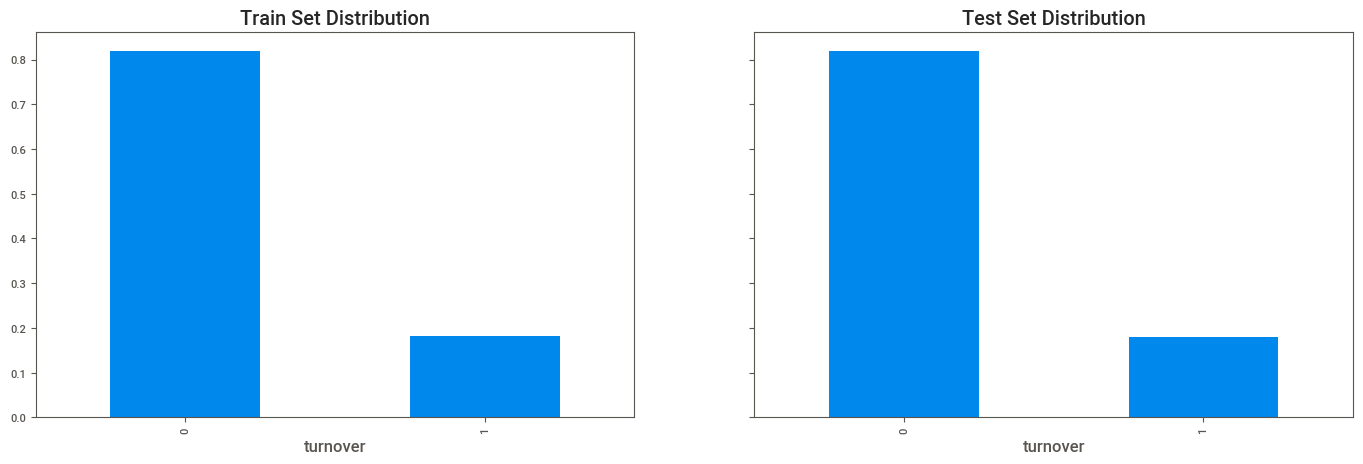

In [19]:
# verify the stratification

fig, axs = plt.subplots(ncols=2, figsize=(17, 5), sharey=True)
df_train['turnover'].value_counts(normalize=True).plot(kind='bar', ax=axs[0])
axs[0].set_title("Train Set Distribution")

df_test['turnover'].value_counts(normalize=True).plot(kind='bar', ax=axs[1])
axs[1].set_title('Test Set Distribution')
plt.show()

In [20]:
df_train.head(5)

,age,gender,marital_status,turnover,department,role,role_grade,qualifications_held,years_work_experience,education_field,...,traveling,regular_overtime,percent_salary_hike,shares_option_level,training_times_last_year,work_life_balance_score,years_at_company,years_in_current_role,years_with_current_manager,distance_from_home
849,30,F,Single,0,Research & Development,Laboratory Technician,1,1,8,Technical Degree,...,Sometimes,Yes,17,0,3,4,2,2,2,2
1149,44,F,Married,0,Research & Development,Laboratory Technician,1,4,7,Life Sciences,...,Sometimes,No,12,1,2,1,5,2,3,16
279,34,F,Single,0,Research & Development,Research Scientist,2,4,1,Life Sciences,...,Sometimes,No,13,0,1,2,19,7,0,7
1010,35,M,Married,0,Research & Development,Research Scientist,1,2,2,Medical,...,Sometimes,No,13,1,3,3,1,1,1,8
625,51,M,Single,0,Research & Development,Research Scientist,2,4,9,Life Sciences,...,Sometimes,Yes,20,0,3,2,6,1,3,1


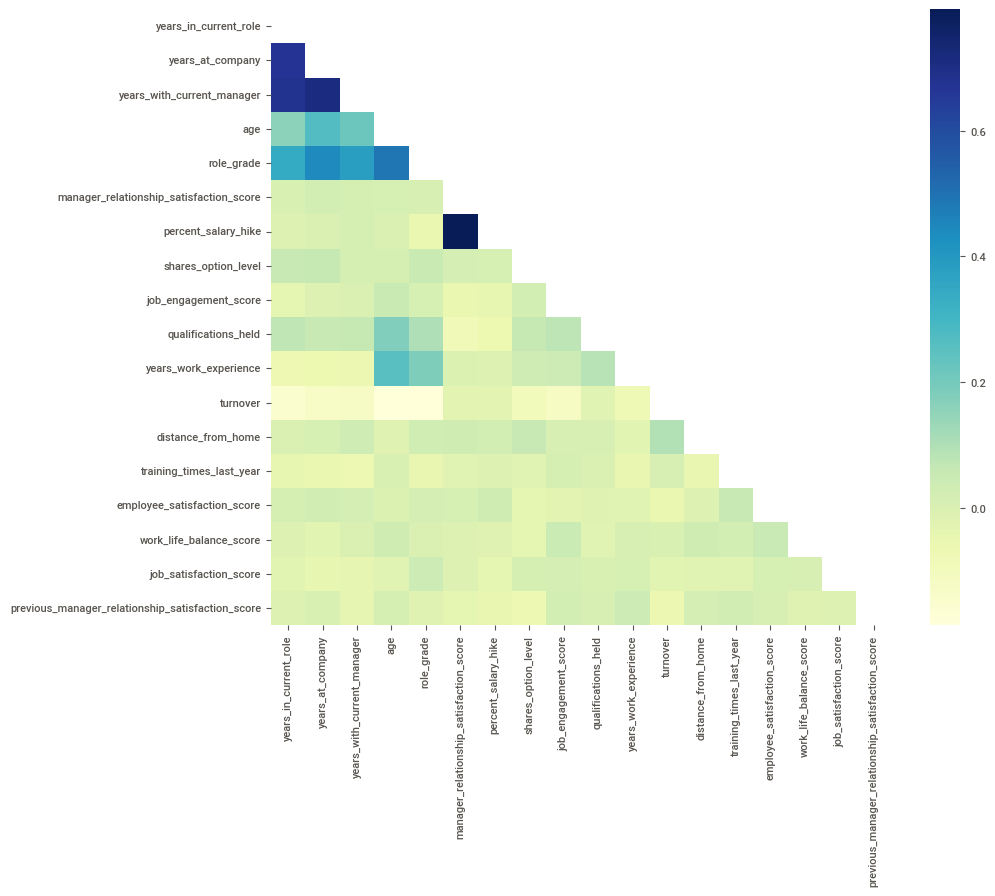

In [21]:
# Select only numerical columns
numerical_columns = df_train.select_dtypes(include=np.number)

# Compute the correlation matrix for numerical columns
corr = numerical_columns.corr()

# Perform hierarchical clustering to find the optimal ordering
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=corr.columns.tolist(), no_plot=True)
sort_order = dendro['leaves']

# Reorder the correlation matrix according to the clustering
sorted_corr = corr.iloc[sort_order, sort_order]

# Create a mask to hide the upper triangle of the heatmap
mask = np.triu(np.ones_like(sorted_corr, dtype=bool))

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(sorted_corr, mask=mask, ax=ax, cmap='YlGnBu', annot=True)
plt.show()

In [22]:
def classification_report_viz(model, X_train, X_test, y_train, y_test, classes):
    '''
    simple classification report from yellowbrick
    '''
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(model, classes=classes, support=True)

    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    plt.clf()


In [23]:
# confusion matrix plot
def visualize_classification(y_test, y_pred):
    """
    Visualizes the classification performance by displaying a classification report
    and a confusion matrix heatmap.
    """
    cr = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(cr)
    # Generate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred.round())

    plt.figure(figsize=(10, 7))
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

In [24]:
def plot_roc_cm(y_true, y_pred, model, name):
    # compute fpr and tpr for roc curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # compute the confusion matrix
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)
    mat = confusion_matrix(y_true, y_pred_binary)
    cr = classification_report(y_true, y_pred_binary)
    print(cr)

    # plot the ROC curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    ax1.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve of {}'.format(name))
    ax1.legend(loc='lower right')

    # plot the confusion matrix
    names = ["True Negative", "False Positive", "False Negative", "True Positive"]
    counts = ["{0:0.0f}".format(value) for value in mat.flatten()]
    percents = ["{0:.2%}".format(value) for value in mat.flatten()/np.sum(mat)]
    labels = ["{}\n{}\n{}".format(a, b, c) for a, b, c in zip(names, counts, percents)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(mat, annot=labels, fmt="", cmap="Blues", ax=ax2)
    ax2.set(xlabel="Predicted", ylabel="Actual",
       title='Confusion Matrix of {}'.format(name))

    plt.tight_layout()
    plt.show()

In [25]:
# Convert role_grade to categorical datatype with specified categories for training data
categories = [1, 2, 3, 4, 5]  # Define the categories in ascending order

# Convert role_grade to categorical datatype with specified categories for testing data
df_test['role_grade'] = pd.Categorical(df_test['role_grade'], categories=categories, ordered=True)
df_train['role_grade'] = pd.Categorical(df_train['role_grade'], categories=categories, ordered=True)

# Check the datatype and categories of role_grade column for testing data
print(df_test['role_grade'].dtype)
print(df_test['role_grade'].cat.categories)

# Check the datatype and categories of role_grade column for training data
print(df_train['role_grade'].dtype)
print(df_train['role_grade'].cat.categories)

category
Index([1, 2, 3, 4, 5], dtype='int64')
category
Index([1, 2, 3, 4, 5], dtype='int64')


In [26]:
columns_to_encode = ['role', 'gender', 'marital_status', 'traveling', 'department', 'qualifications_held', 'education_field']

# One-hot encoding the specified columns
encoded_df_train = pd.get_dummies(df_train[columns_to_encode], drop_first=True)
encoded_df_test = pd.get_dummies(df_test[columns_to_encode], drop_first=True)

# Drop the original categorical columns
df_train.drop(columns=columns_to_encode, inplace=True)
df_test.drop(columns=columns_to_encode, inplace=True)

# Concatenate the encoded DataFrame with the original DataFrame
df_train = pd.concat([df_train, encoded_df_train], axis=1)
df_test = pd.concat([df_test, encoded_df_test], axis=1)

In [27]:
# Binary encoding for training data

df_train['regular_overtime'] = df_train['regular_overtime'].replace({'No': 0, 'Yes': 1}).astype(int)
df_test['regular_overtime'] = df_test['regular_overtime'].replace({'No': 0, 'Yes': 1}).astype(int)

In [28]:
# Aggregate scores columns to provide a total score per employee for training data
df_train['AggregateScore'] = df_train[['employee_satisfaction_score', 'job_engagement_score', 'job_satisfaction_score',
                                       'previous_manager_relationship_satisfaction_score', 'manager_relationship_satisfaction_score',
                                       'work_life_balance_score']].sum(axis=1)

# Aggregate scores columns to provide a total score per employee for testing data
df_test['AggregateScore'] = df_test[['employee_satisfaction_score', 'job_engagement_score', 'job_satisfaction_score',
                                     'previous_manager_relationship_satisfaction_score', 'manager_relationship_satisfaction_score',
                                     'work_life_balance_score']].sum(axis=1)

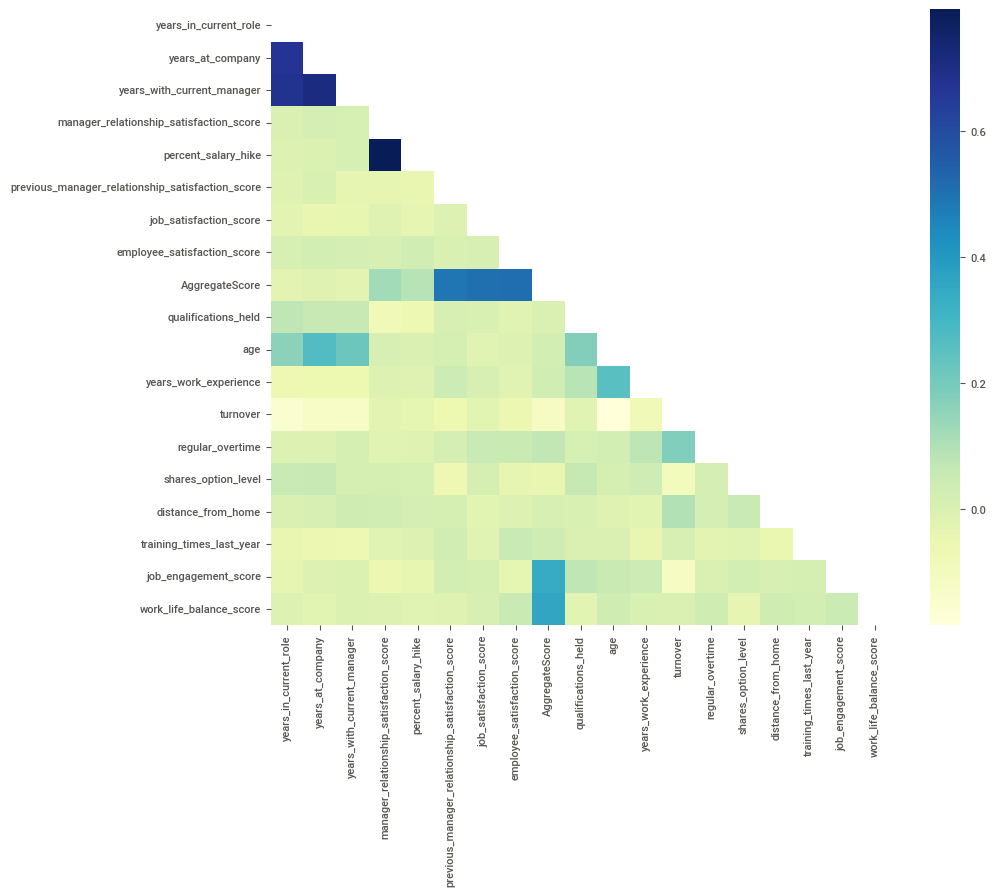

In [29]:
# Select only numerical columns
numerical_columns = df_train.select_dtypes(include=np.number)

# Compute the correlation matrix for numerical columns
corr = numerical_columns.corr()

# Perform hierarchical clustering to find the optimal ordering
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=corr.columns.tolist(), no_plot=True)
sort_order = dendro['leaves']

# Reorder the correlation matrix according to the clustering
sorted_corr = corr.iloc[sort_order, sort_order]

# Create a mask to hide the upper triangle of the heatmap
mask = np.triu(np.ones_like(sorted_corr, dtype=bool))

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(sorted_corr, mask=mask, ax=ax, cmap='YlGnBu', annot=True)
plt.show()

In [30]:
df_train.head(5)

,age,turnover,role_grade,years_work_experience,employee_satisfaction_score,job_engagement_score,job_satisfaction_score,previous_manager_relationship_satisfaction_score,manager_relationship_satisfaction_score,regular_overtime,...,traveling_No,traveling_Sometimes,department_Research & Development,department_Sales,education_field_Life Sciences,education_field_Marketing,education_field_Medical,education_field_Other,education_field_Technical Degree,AggregateScore
849,30,0,1,8,4,1,4,2,3,1,...,False,True,True,False,False,False,False,False,True,18
1149,44,0,1,7,4,2,3,4,3,0,...,False,True,True,False,True,False,False,False,False,17
279,34,0,2,1,4,3,4,4,3,0,...,False,True,True,False,True,False,False,False,False,20
1010,35,0,1,2,1,4,3,3,3,0,...,False,True,True,False,False,False,True,False,False,17
625,51,0,2,9,2,2,1,4,4,1,...,False,True,True,False,True,False,False,False,False,15


In [31]:
# feature importance plot

def feat_importance(df, target):
    '''
    Feature importance plot function
    '''
    if isinstance(df, pd.DataFrame):
        X = df.drop([target], axis=1)
        y = df[target]
        from sklearn.ensemble import RandomForestClassifier
        forest = RandomForestClassifier(n_estimators=10, max_depth=4, min_samples_leaf=15,
                                min_samples_split=10, random_state=42)
        forest.fit(X,y)

        # visualize
        sns.set()
        plt.figure(figsize=(10,8))
        importances = pd.Series(forest.feature_importances_, index=X.columns)
        importances.nlargest(15).sort_values().plot(kind='barh')
        plt.title('Random Forest Feature Importance Plot', fontsize=16)
        plt.xlabel('Feature Importance')
        plt.show()
    else:
        print('pd.DataFrame object needed')

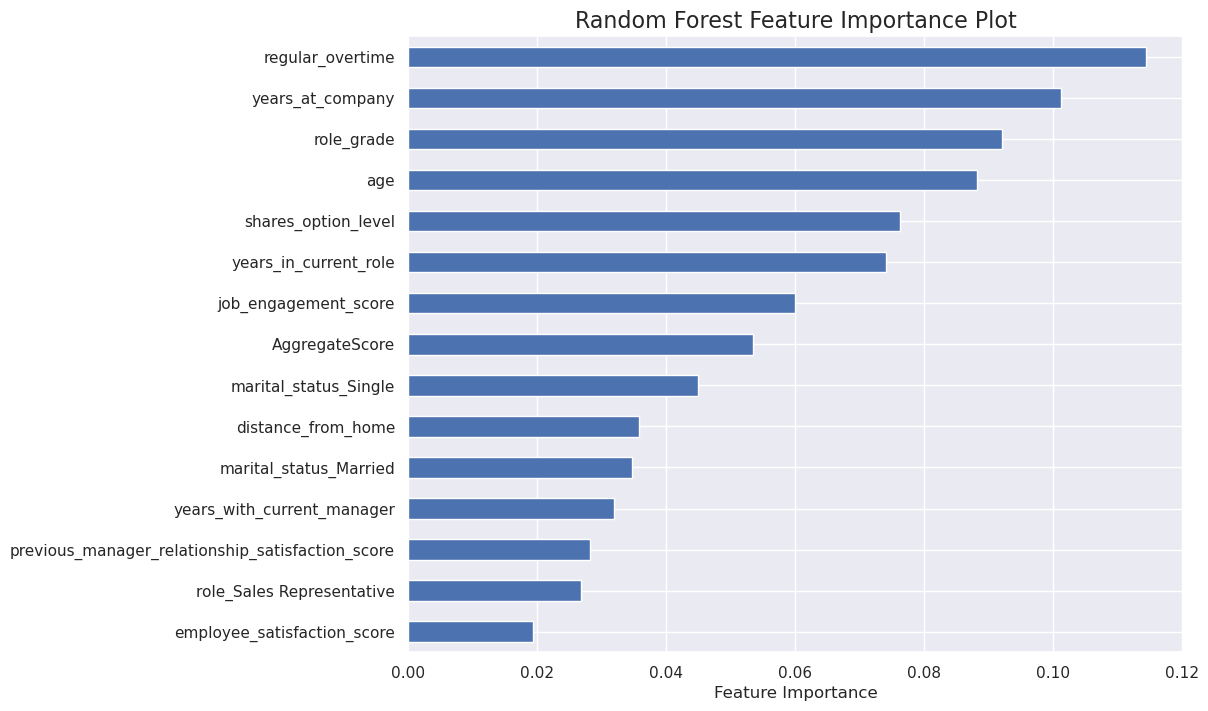

In [32]:
# which columns do we need to drop?
feat_importance(df_train, 'turnover')

I've ignored 'education_field_life_sciences' and 'role_laboratory_technician' as I think they are coincidental & not actually going to affect the model

In [33]:
# split

cols_to_drop = ['employee_satisfaction_score', 'previous_manager_relationship_satisfaction_score',
       'manager_relationship_satisfaction_score', 'training_times_last_year', 'work_life_balance_score', 'qualifications_held', 'role_Human Resources',
       'role_Laboratory Technician', 'role_Manager',
       'role_Manufacturing Director', 'role_Research Director',
       'role_Research Scientist', 'role_Sales Executive',
       'role_Sales Representative', 'gender_M', 'marital_status_Married',
       'marital_status_Single', 'traveling_No', 'traveling_Sometimes',
       'department_Research & Development', 'department_Sales',
       'education_field_Life Sciences', 'education_field_Marketing',
       'education_field_Medical', 'education_field_Other',
       'education_field_Technical Degree']

X_train = df_train.drop(cols_to_drop, axis=1)
X_test = df_test.drop(cols_to_drop, axis=1)

y_train = df_train['turnover']
y_test = df_test['turnover']

print("The shape of the training feature matrix (X_train) is", X_train.shape)
print("The shape of the testing feature matrix (X_test) is", X_test.shape)
print("The shape of the training target vector (y_train) is", y_train.shape)
print("The shape of the testing target vector (y_test) is", y_test.shape)

The shape of the training feature matrix (X_train) is (1176, 14)
The shape of the testing feature matrix (X_test) is (294, 14)
The shape of the training target vector (y_train) is (1176,)
The shape of the testing target vector (y_test) is (294,)


In [34]:
# scaling the data

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
# load the lazyclassifier engine - specify settings

classifier = LazyClassifier(verbose=0, ignore_warnings=True,
                     custom_metric=None, predictions=True)

# run the lazyclassifier engine

models, predictions = classifier.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:02<00:00, 12.24it/s]

[LightGBM] [Info] Number of positive: 214, number of negative: 962
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 1176, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181973 -> initscore=-1.503038
[LightGBM] [Info] Start training from score -1.503038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [36]:
models.sort_values(by=['F1 Score','Balanced Accuracy'], ascending=False, axis=0)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,1.00,1.00,1.00,1.00,0.02
BaggingClassifier,1.00,1.00,1.00,1.00,0.03
XGBClassifier,1.00,1.00,1.00,1.00,0.22
SVC,1.00,1.00,1.00,1.00,0.14
SGDClassifier,1.00,1.00,1.00,1.00,0.04
RidgeClassifierCV,1.00,1.00,1.00,1.00,0.05
RidgeClassifier,1.00,1.00,1.00,1.00,0.02
RandomForestClassifier,1.00,1.00,1.00,1.00,0.20
QuadraticDiscriminantAnalysis,1.00,1.00,1.00,1.00,0.01


In [37]:
# train logistic regression

# initialise the model
model = LogisticRegression(class_weight='balanced')

# train the model
model.fit(X_train_scaled, y_train)

# generate y_pred
y_pred = model.predict(X_test_scaled)

accuracy = met.accuracy_score(y_test, y_pred)
balanced_accuracy = met.balanced_accuracy_score(y_test, y_pred)
f1 = met.f1_score(y_test, y_pred)

print("Accuracy:", np.round(accuracy*100.0,1))
print("Balanced Accuracy:", np.round(balanced_accuracy*100.0,2))
print("F1-score: ", np.round(f1*100.0,2))

Accuracy: 100.0
Balanced Accuracy: 100.0
F1-score:  100.0


In [38]:
# train the model and evaluate it

# initialise the model
model = RandomForestClassifier(n_estimators=500, max_depth=3, class_weight='balanced')

# train the model
model.fit(X_train_scaled, y_train)

# generate y_pred
y_pred = model.predict(X_test_scaled)

accuracy = met.accuracy_score(y_test, y_pred)
balanced_accuracy = met.balanced_accuracy_score(y_test, y_pred)
f1 = met.f1_score(y_test, y_pred)

print("Accuracy:", np.round(accuracy*100.0,1))
print("Balanced Accuracy:", np.round(balanced_accuracy*100.0,2))
print("F1-score: ", np.round(f1*100.0,2))

Accuracy: 100.0
Balanced Accuracy: 100.0
F1-score:  100.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       1.00      1.00      1.00        53

    accuracy                           1.00       294
   macro avg       1.00      1.00      1.00       294
weighted avg       1.00      1.00      1.00       294



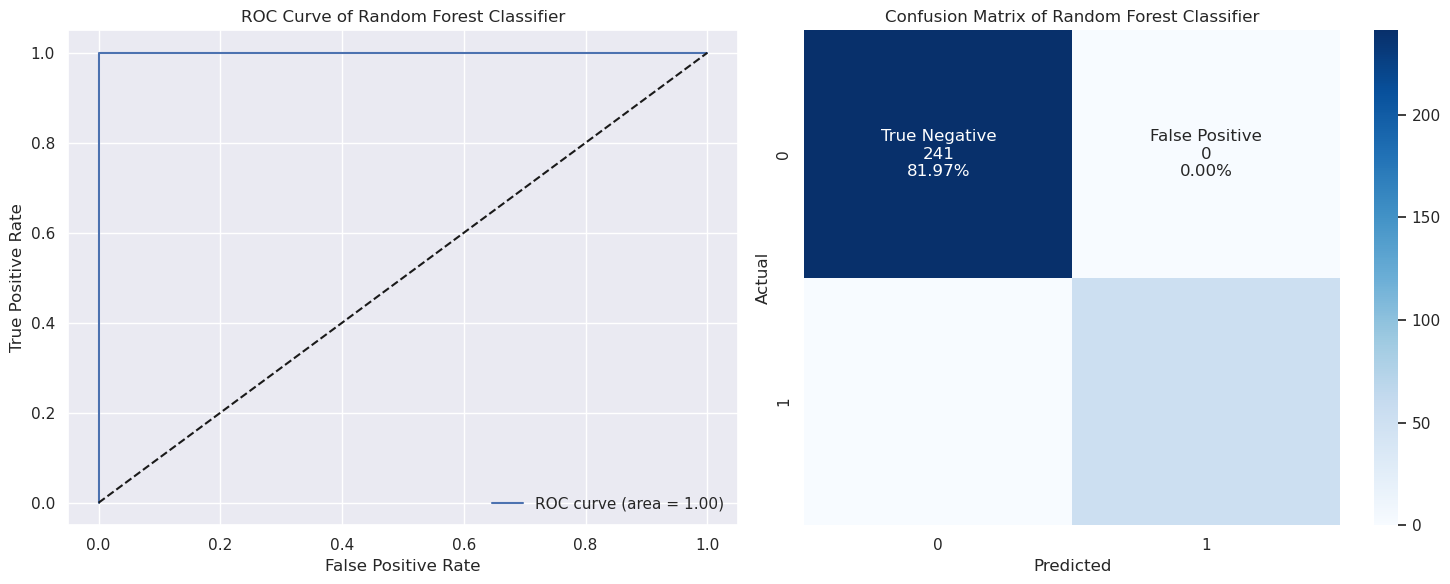

In [39]:
# confusion matrix 

plot_roc_cm(y_test, y_pred, model, 'Random Forest Classifier')

# Interpreting the Model 

In [40]:
X_train.columns

Index(['age', 'turnover', 'role_grade', 'years_work_experience',
       'job_engagement_score', 'job_satisfaction_score', 'regular_overtime',
       'percent_salary_hike', 'shares_option_level', 'years_at_company',
       'years_in_current_role', 'years_with_current_manager',
       'distance_from_home', 'AggregateScore'],
      dtype='object')

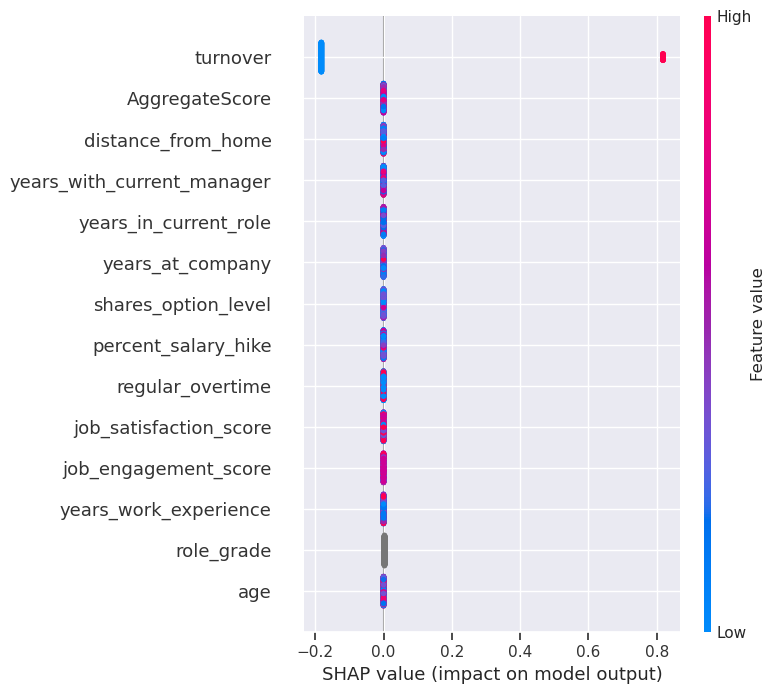

In [41]:
# example of SHAP

dtree = tree.DecisionTreeRegressor(min_samples_split=20)
dtree.fit(X_train, y_train)

# explain all the predictions in the test set
ex = shap.TreeExplainer(dtree)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [42]:
# what are the feature numbers

features = X_train.columns

for i, name, in enumerate(features):
    print(i, name)

0 age
1 turnover
2 role_grade
3 years_work_experience
4 job_engagement_score
5 job_satisfaction_score
6 regular_overtime
7 percent_salary_hike
8 shares_option_level
9 years_at_company
10 years_in_current_role
11 years_with_current_manager
12 distance_from_home
13 AggregateScore


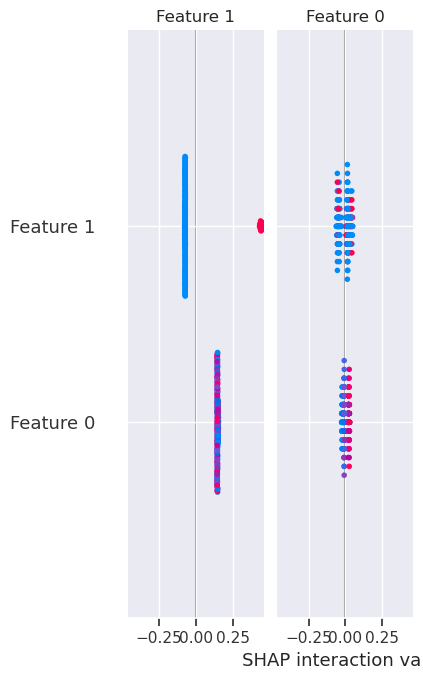

In [43]:
ex = shap.Explainer(model, X_train_scaled)

# we calculate SHAP values for the test set
shap_values = ex.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled)